## Read this

- https://s.id/PanduanPenggunaanDGXA100
-

## Import Libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!pip uninstall transformers --y
!pip install transformers==4.35

Found existing installation: transformers 4.35.0
Uninstalling transformers-4.35.0:
  Successfully uninstalled transformers-4.35.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.5 MB/s eta 0:00:00


In [3]:
!pip install jupyter

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!pip uninstall traitlets --y
!pip install traitlets==5.9.0

Found existing installation: traitlets 5.9.0
Uninstalling traitlets-5.9.0:
  Successfully uninstalled traitlets-5.9.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 2.7 MB/s eta 0:00:00


In [4]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import os
import pandas as pd
import numpy as np
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler

from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

# from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Download Model

In [3]:
tokenizer_class = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
# model_class = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Data collator is used for padding in batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_class)

In [4]:
class BERT_Lexidqa2_class(nn.Module):
    def __init__(self, bert, input_size = 768, output_size = 18):
        super().__init__()

        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu = nn.ReLU()

        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, output_size)

        self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
              4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
              9: "T10", 10: "T11", 11: "T12", 12: "T13",
              13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

    def forward(self, x):
        x, _ = self.bert(x, return_dict=False)

        # Only take the first column, Pooled Output, The Context
        x = x[:, 0, :]
        x = x.view(-1, 768)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)

        return x

    def predict(input):
      output = self.forward(torch.tensor(input['input_ids']).view(1, -1))

      id_max = torch.argmax(output)
      return self.id2label[id_max.item()]

In [5]:
save_path = 'model/class/'
model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

bert_class = torch.load(model_class_path)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [6]:
print(bert_class)

BERT_Lexidqa2_class(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# Variables

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# LexID QA 2 Using BERT

## Semantic Dataset Class

In [8]:
class Lexidqa2SemanticDataset(Dataset):
  """LexID QA2 Semantic Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    self.label2id = {"TS": 0, "T1": 1, "T2": 2, "T3": 3, "T4": 4,
                "T5": 5, "T6": 6, "T7": 7, "T8": 8, "T9": 9,
                "T10": 10, "T11": 11, "T12": 12, "T13": 13,
                "T14": 14, "T15": 15, "T16": 16, "T17": 17, "T18": 18}
    self.id2label = {0: "TS", 1: "T1", 2: "T2", 3: "T3", 4: "T4",
                5: "T5", 6: "T6", 7: "T7", 8: "T8", 9: "T9",
                10: "T10", 11: "T11", 12: "T12", 13: "T13",
                14: "T14", 15: "T15", 16: "T16", 17: "T17", 18: "T18"}

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "question"]
    question_tokenized = self.tokenizer(question, truncation=True)
    question_input_ids = torch.tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "answer"]
    template_label = self.qa_frame.loc[idx, "template_index"]

    template_id = self.one_hot(template_label, self.label2id)

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              template_label,
              template_id)

    return sample

  def one_hot(self, label, label2id):
    one_hot_label = torch.zeros(len(label2id))
    one_hot_label[label2id[label]] = 1

    return one_hot_label

## Dataset

In [32]:
train_df = pd.read_csv("dataset/train_tesaurus.csv")
train_dataset = Lexidqa2SemanticDataset(train_df, tokenizer_class)

In [33]:
test_df = pd.read_csv("dataset/test_tesaurus.csv")
test_dataset = Lexidqa2SemanticDataset(test_df, tokenizer_class)

In [12]:
# semantic_df = pd.read_csv("semantic/dataset/dataset_semantic.csv")
# semantic_dataset = Lexidqa2SemanticDataset(semantic_df, tokenizer_class)

# num_row, _ = t_index.shape
# two_thousands = np.min([2000, num_row])
# print("tS: " + str(two_thousands))

# semantic_df = semantic_df[:two_thousands].copy().reset_index()

In [34]:
t = pd.read_csv('semantic/dataset/sampleQ6ner.csv')

read_path = "semantic/dataset/dataset_semantic.csv"
t_index = pd.read_csv(read_path)

num_row, _ = t_index.shape
two_thousands = np.min([2000, num_row])
print("tS: " + str(two_thousands))
t = pd.concat([t, t_index[:two_thousands]], ignore_index=True)

semantic_df = t
semantic_dataset = Lexidqa2SemanticDataset(t, tokenizer_class)
print(len(semantic_dataset))

t.head()

tS: 802
952


,question,answer,ner,complete_sentence,rule,template_index
0,apa dasar dari setiap keputusan yang dilakukan...,ketentuan peraturan perundang-undangan dan aupb,"['O', 'B-SBJ', 'B-QTY', 'B-QVA', 'I-QVA', 'O',...",apa dasar dari setiap keputusan yang dilakukan...,UU_2014_30,TS
1,dari manakah kewenangan pemerintahan diperoleh?,"melalui atriburi, delegasi, dan/atau mandat","['B-QTY', 'B-QVA', 'B-SBJ', 'I-SBJ', 'B-ACT']",dari manakah kewenangan pemerintahan diperoleh?,UU_2014_30,TS
2,apa bentuk keputusan yang mengakibatkan pembeb...,bentuk tertulis,"['O', 'B-SBJ', 'I-SBJ', 'O', 'B-ACT', 'B-OBJ',...",apa bentuk keputusan yang mengakibatkan pembeb...,UU_2014_30,TS
3,siapa yang berhak melaporkan keterangan adanya...,warga masyarakat,"['O', 'O', 'B-ACT', 'B-OBJ', 'I-OBJ', 'B-QTY',...",siapa yang berhak melaporkan keterangan adanya...,UU_2014_30,TS
4,apakah alasan pertimbangan yang harus diberika...,"pertimbangan yuridis, sosiologis, dan filosofis","['O', 'B-SBJ', 'I-SBJ', 'O', 'B-MDL', 'B-ACT',...",apakah alasan pertimbangan yang harus diberika...,UU_2014_30,TS


## Sample from dataset

In [35]:
np.random.seed(12345)
random_indices = np.random.choice(range(len(semantic_dataset)), size=5, replace=False)

for i in random_indices:
  sample = semantic_dataset[i]

  print(i, sample[0])

  if i == 5:
    break

207 Sesuai Dengan Ketentuan Peraturan Perundang Undangan, apakah Personil Wajib Memiliki Kompetensi
709 Apa yang Wajib Penyedia Jasa Pelayanan Pengelolaan Sampah Memiliki Dari Bupati
430 Dari Direktur Jenderal, apa yang Harus Dokumen Pelaksanaan Anggaran Perubahan Mendapatkan
0 apa dasar dari setiap keputusan yang dilakukan oleh pejabat pemerintahan?
181 Sesuai Dengan apa Fungsi Bangunan Gedung Dapat Dilengkapi Prasarana Bangunan Gedung


In [36]:
BATCH_SIZE = 32
torch.manual_seed(12345)

train_idx, test_idx = train_test_split(np.arange(len(semantic_dataset)), test_size=0.20, random_state=12345, shuffle=True)

train_size = len(train_idx)
test_size = len(test_idx)

### Save train test data to CSV

In [37]:
# train_semantic_df = semantic_df.iloc[train_idx]
# save_path = 'semantic/dataset'
# if not os.path.exists(save_path):
#   os.makedirs(save_path)
# train_semantic_df.to_csv('semantic/dataset/train_semantic.csv', index=False)

In [38]:
# test_semantic_df = semantic_df.iloc[test_idx]
# save_path = 'semantic/dataset'
# if not os.path.exists(save_path):
#   os.makedirs(save_path)
# test_semantic_df.to_csv('semantic/dataset/test_semantic.csv', index=False)

## Split, DataLoader

In [39]:
def collate_fn_class(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, input_ids, _, _, _, _, label_ids = zip(*data)
    features = pad_sequence(input_ids, batch_first=True)
    targets = torch.stack(label_ids)
    return features, targets

### Prepare for KFold

### Load train test data

In [40]:
train_df = pd.read_csv('dataset/train_tesaurus.csv')
train_df['template_index'].value_counts()

T4     1500
T7     1500
T10    1500
T3     1500
T9     1500
T18    1500
T5     1500
T16    1500
T11    1500
T12    1500
T1     1500
T6     1500
T13    1500
T8     1500
T17    1500
T2     1500
T15     716
T14     235
Name: template_index, dtype: int64

In [41]:
test_df = pd.read_csv('dataset/test_tesaurus.csv')
test_df['template_index'].value_counts()

T17    500
T10    500
T13    500
T3     500
T2     500
T8     500
T11    500
T12    500
T4     500
T5     500
T9     500
T7     500
T18    500
T6     500
T1     500
T16    500
T15    239
T14     79
Name: template_index, dtype: int64

In [42]:
train_semantic_df = pd.read_csv('semantic/dataset/train_semantic.csv')
train_semantic_df['template_index'].value_counts()

TS    761
Name: template_index, dtype: int64

In [43]:
test_semantic_df = pd.read_csv('semantic/dataset/test_semantic.csv')
test_semantic_df['template_index'].value_counts()

TS    191
Name: template_index, dtype: int64

In [44]:
BATCH_SIZE = 64
torch.manual_seed(12345)

train_normal_df = pd.read_csv('dataset/train_tesaurus.csv')
test_normal_df = pd.read_csv('dataset/test_tesaurus.csv')

train_semantic_df = pd.read_csv('semantic/dataset/train_semantic.csv')
test_semantic_df = pd.read_csv('semantic/dataset/test_semantic.csv')

train_df = pd.concat([train_normal_df, train_semantic_df], ignore_index=True)
test_df = pd.concat([test_normal_df, test_semantic_df], ignore_index=True)

data_all_label = [train_df.loc[i, 'template_index'] for i in range(len(train_df))]

samples_strategy = {
    'T1': 500, 'T2': 500, 'T3': 500, 'T4': 500, 'T5': 500, 'T6': 500,
    'T7': 500, 'T8': 500, 'T9': 500, 'T10': 500, 'T11': 500, 'T12': 500,
    'T13': 500, 'T15': 500,  'T16': 500, 'T17': 500, 'T18': 500
}

rus = RandomUnderSampler(random_state=12345, sampling_strategy=samples_strategy)
train_df, _ = rus.fit_resample(train_df, data_all_label)
train_df = train_df.reset_index(drop=True)

qa_dataset_train = Lexidqa2SemanticDataset(train_df, tokenizer_class)
qa_dataset_test = Lexidqa2SemanticDataset(test_df, tokenizer_class)

# qa_dataset_train_semantic = Lexidqa2SemanticDataset(train_semantic_df, tokenizer_class)
# qa_dataset_test_semantic = Lexidqa2SemanticDataset(test_semantic_df, tokenizer_class)

# # data_all_label = [qa_dataset[i][5] for i in range(len(qa_dataset))]
# # train_idx, test_idx = train_test_split(np.arange(len(qa_dataset)), test_size=0.25, random_state=12345, shuffle=True, stratify=data_all_label)

train_size = len(qa_dataset_train)
test_size = len(qa_dataset_test)
# train_semantic_size = len(qa_dataset_train_semantic)
# test_semantic_size = len(qa_dataset_test_semantic)

data_train_label = [qa_dataset_train[i][5] for i in range(train_size)]

# test_dataset = Subset(qa_dataset, test_idx)
test_instances = DataLoader(qa_dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)
# test_semantic_instances = DataLoader(qa_dataset_test_semantic, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

# Classification

## Model

### Loss Function

> Loss Function Multi-Class Classification: CrossEntropyLoss

In [45]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')

### Evaluation Function

In [46]:
def confusion_matrix(gold, pred, conf_matrix):
  _, gold = torch.max(gold, 1)
  _, pred = torch.max(pred, 1)
  for g, p in zip(gold.view(-1), pred.view(-1)):
    conf_matrix[g.long(), p.long()] += 1

  return conf_matrix

In [47]:
def evaluation_metric(conf_matrix):
  nb_classes = 19
  display_labels = ['TS', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']

  amt = amount(conf_matrix)
  # print(f"Debug Amount: {amt}")
  acc = accuracy(conf_matrix)
  prec = precision(conf_matrix)
  rec = recall(conf_matrix)
  f1 = fone(prec, rec)

  return amt, acc, prec, rec, f1

def amount(conf_matrix):
  return conf_matrix.sum(1)

def accuracy(conf_matrix):
  return conf_matrix.diag()/conf_matrix.sum(1)

def precision(conf_matrix):
  nb_classes = 19

  prec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_positive = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[col, index]
      else:
        false_positive += conf_matrix[col, index]
    prec[index] = true_positive / (true_positive + false_positive)

  return prec

def recall(conf_matrix):
  nb_classes = 19

  rec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_negative = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[index, col]
      else:
        false_negative += conf_matrix[index, col]
    rec[index] = true_positive / (true_positive + false_negative)

  return rec

def fone(prec, rec):
  nb_classes = 19

  f1 = torch.zeros(nb_classes)
  for index in range(nb_classes):
    f1[index] = 2 * (prec[index] * rec[index]) / (prec[index] + rec[index])

  return f1

### BERT + Full Connected Layer

In [48]:
class BERT_Lexidqa2_class(nn.Module):
    def __init__(self, bert, input_size = 768, output_size = 18):
        super().__init__()

        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu = nn.ReLU()

        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, output_size)

        self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
              4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
              9: "T10", 10: "T11", 11: "T12", 12: "T13",
              13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

    def forward(self, x):
        x, _ = self.bert(x, return_dict=False)

        # Only take the first column, Pooled Output, The Context
        x = x[:, 0, :]
        x = x.view(-1, 768)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)

        return x

    def predict(input):
      output = self.forward(torch.tensor(input['input_ids']).view(1, -1))

      id_max = torch.argmax(output)
      return self.id2label[id_max.item()]

In [49]:
model = BERT_Lexidqa2_class(bert_class.bert, 768, 19)
with torch.no_grad():
  model.linear1.weight[:] = bert_class.linear1.weight.data.clone()
  model.linear2.weight[1:20] = bert_class.linear2.weight.data.clone()

## Training

> Train using 5-Fold
>
> Save checkpoint every 5 Epoch Max 20 Epoch

0it [00:00, ?it/s]

=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====


0it [00:00, ?it/s]

Fold 1 Ready


0it [00:00, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.04224764440646943


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:05, ?it/s]

Average Loss Validation: 0.005383485823404044
Time 5.029435157775879

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.011086208135390482


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:10, ?it/s]

Average Loss Validation: 0.00245772829997198
Time 5.067158937454224

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0074968031713222505


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:15, ?it/s]

Average Loss Validation: 0.001936421465264478
Time 5.074952840805054

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.008685668635459914


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:20, ?it/s]

Average Loss Validation: 0.0021564659124123863
Time 5.152170658111572

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005422799054145844


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.00234516708466496
Time 5.102214813232422



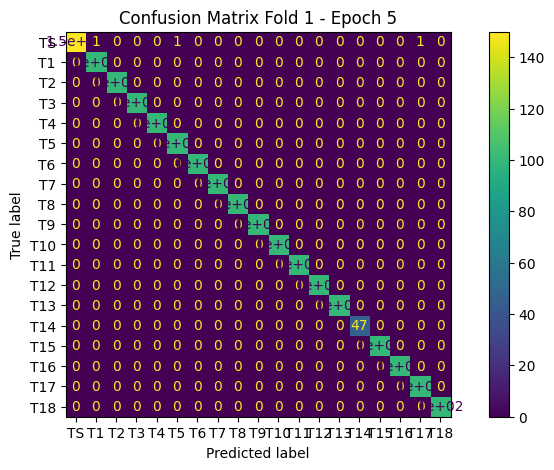

,Amount of Data,Accuracy,Precision,Recall,F One
TS,153.0,0.980392,1.000000,0.980392,0.990099
T1,100.0,1.000000,0.990099,1.000000,0.995025
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,0.990099,1.000000,0.995025
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


0it [00:28, ?it/s]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.006804981122689494


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:33, ?it/s]

Average Loss Validation: 0.0012877654825084997
Time 5.057177782058716

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:07, ?it/s]


Average Loss Train: 0.007501872322432102


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:41, ?it/s]

Average Loss Validation: 0.0002353945876772438
Time 8.741998672485352

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0032387926559230046


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:47, ?it/s]

Average Loss Validation: 0.0005551073440680436
Time 5.0524797439575195

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004798880725181387


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [00:52, ?it/s]

Average Loss Validation: 0.00028602711511969877
Time 5.005361080169678

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0039029253445939404


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.00025923436260200106
Time 5.010061502456665



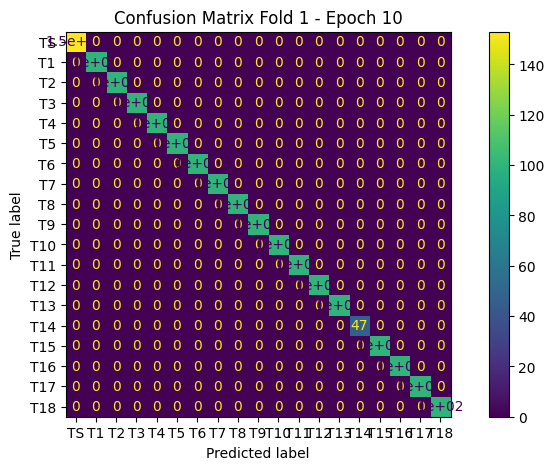

,Amount of Data,Accuracy,Precision,Recall,F One
TS,153.0,1.0,1.0,1.0,1.0
T1,100.0,1.0,1.0,1.0,1.0
T2,100.0,1.0,1.0,1.0,1.0
T3,100.0,1.0,1.0,1.0,1.0
T4,100.0,1.0,1.0,1.0,1.0
T5,100.0,1.0,1.0,1.0,1.0
T6,100.0,1.0,1.0,1.0,1.0
T7,100.0,1.0,1.0,1.0,1.0
T8,100.0,1.0,1.0,1.0,1.0
T9,100.0,1.0,1.0,1.0,1.0


0it [00:59, ?it/s]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004494766857472107


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:04, ?it/s]

Average Loss Validation: 0.00032470568282102856
Time 5.095904111862183

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0032657886616359348


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:09, ?it/s]

Average Loss Validation: 9.380965942303494e-05
Time 5.047771215438843

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0039797233514969055


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:14, ?it/s]

Average Loss Validation: 0.0006966007541147216
Time 5.065532207489014

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:08, ?it/s]


Average Loss Train: 0.004996418862695563


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:24, ?it/s]

Average Loss Validation: 0.0012536349166718233
Time 9.527819395065308

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004125315599395901


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.00012407851269623886
Time 5.153731346130371



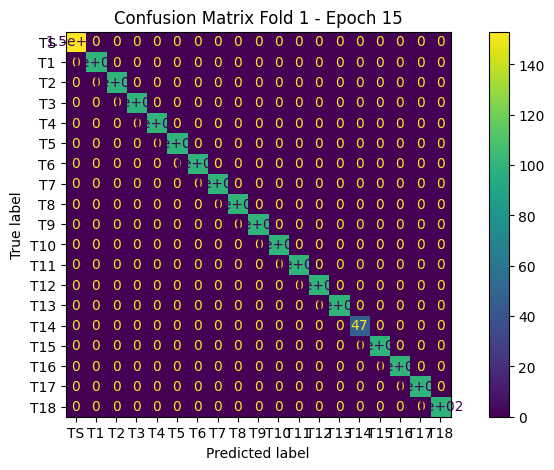

,Amount of Data,Accuracy,Precision,Recall,F One
TS,153.0,1.0,1.0,1.0,1.0
T1,100.0,1.0,1.0,1.0,1.0
T2,100.0,1.0,1.0,1.0,1.0
T3,100.0,1.0,1.0,1.0,1.0
T4,100.0,1.0,1.0,1.0,1.0
T5,100.0,1.0,1.0,1.0,1.0
T6,100.0,1.0,1.0,1.0,1.0
T7,100.0,1.0,1.0,1.0,1.0
T8,100.0,1.0,1.0,1.0,1.0
T9,100.0,1.0,1.0,1.0,1.0


0it [01:32, ?it/s]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.002941383348367991


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:37, ?it/s]

Average Loss Validation: 6.405671301763504e-05
Time 5.188819646835327

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003231026964607461


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:42, ?it/s]

Average Loss Validation: 0.00046749533733721665
Time 5.057773113250732

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0022305514378044675


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:47, ?it/s]

Average Loss Validation: 0.00010067593460310794
Time 5.086394309997559

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0038192506648204875


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
0it [01:52, ?it/s]

Average Loss Validation: 0.0001516965551672911
Time 5.060569524765015

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.00461416024739899


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.00011392361363202022
Time 5.0468034744262695



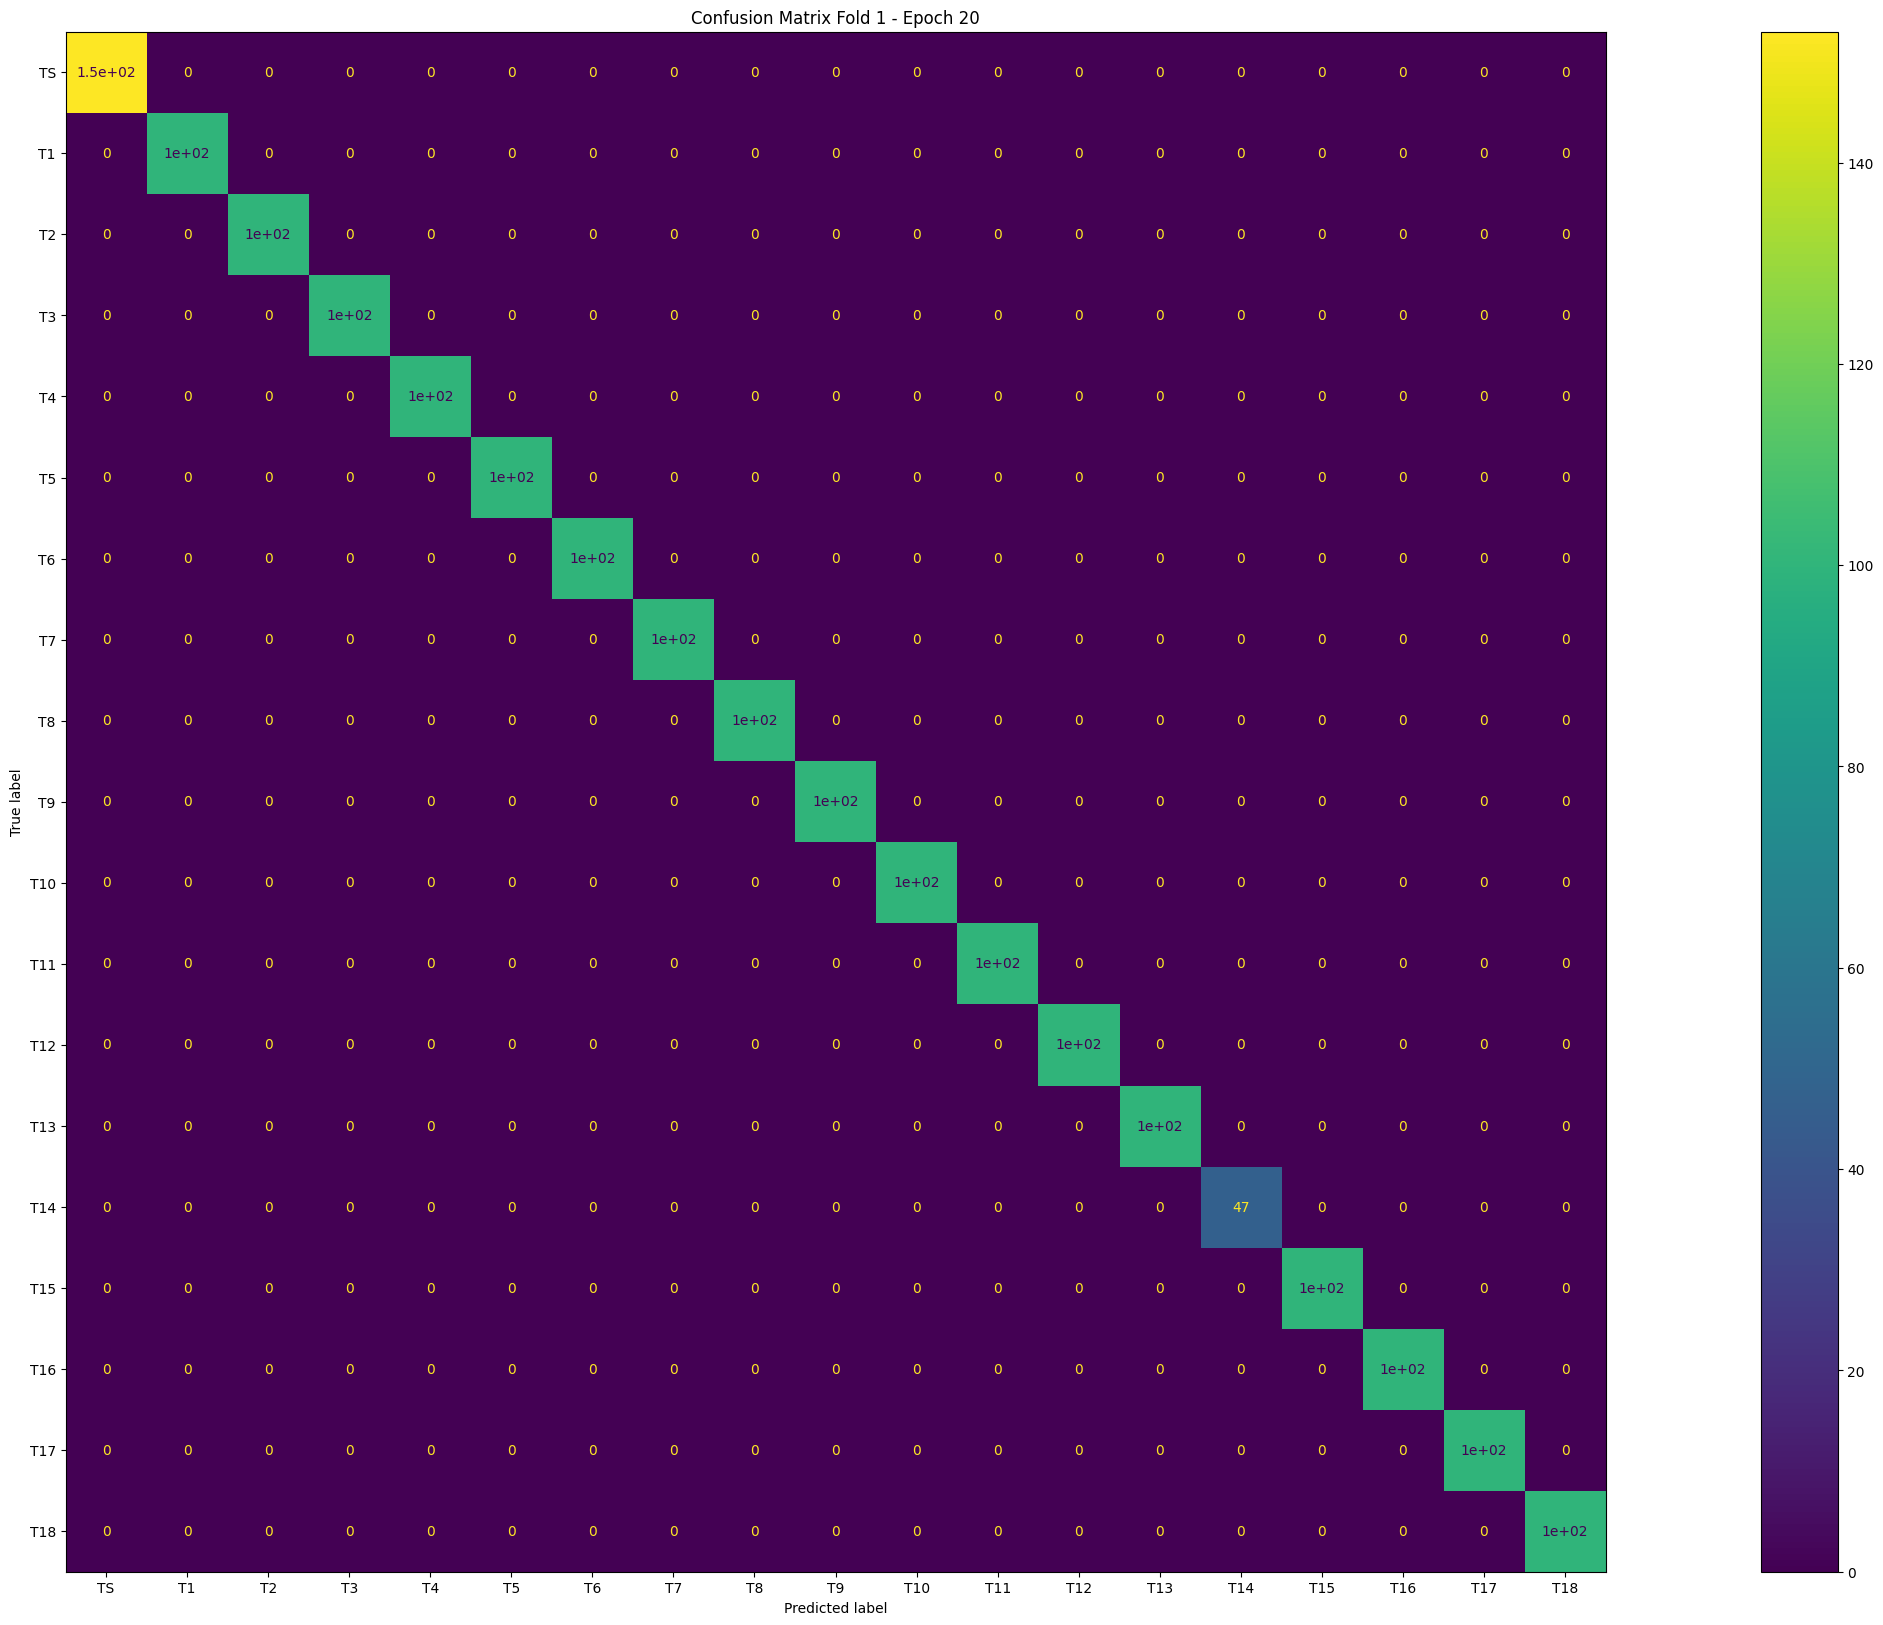

,Amount of Data,Accuracy,Precision,Recall,F One
TS,153.0,1.0,1.0,1.0,1.0
T1,100.0,1.0,1.0,1.0,1.0
T2,100.0,1.0,1.0,1.0,1.0
T3,100.0,1.0,1.0,1.0,1.0
T4,100.0,1.0,1.0,1.0,1.0
T5,100.0,1.0,1.0,1.0,1.0
T6,100.0,1.0,1.0,1.0,1.0
T7,100.0,1.0,1.0,1.0,1.0
T8,100.0,1.0,1.0,1.0,1.0
T9,100.0,1.0,1.0,1.0,1.0


100%|███████████████████████████████████████████| 20/20 [02:00<00:00,  6.01s/it]
1it [02:00, 120.34s/it]

=====:=====:=====:=====:===== Fold 2 =====:=====:=====:=====:=====
Fold 2 Ready


1it [02:00, 120.34s/it]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.04197574963307932


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:05, 120.34s/it]

Average Loss Validation: 0.006785370428891231
Time 5.069506406784058

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.011791815151687429


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:10, 120.34s/it]

Average Loss Validation: 0.003146332644003754
Time 5.024592161178589

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.007008595712494669


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:15, 120.34s/it]

Average Loss Validation: 0.0039884269184161285
Time 4.983362197875977

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.009397844938530015


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:20, 120.34s/it]

Average Loss Validation: 0.0010352368558718202
Time 4.9735634326934814

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0056239369260773315


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.001395488655786418
Time 5.026135206222534



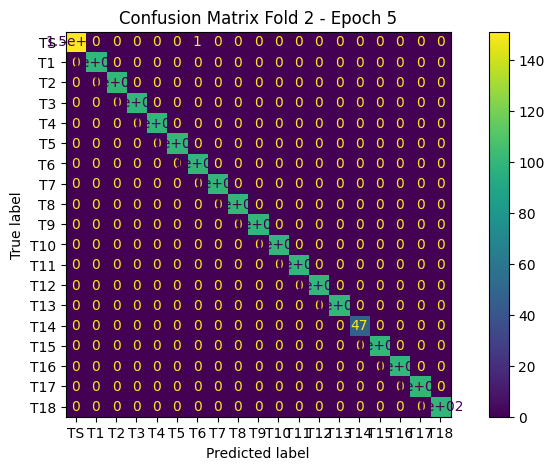

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.993421,1.000000,0.993421,0.996700
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,0.990099,1.000000,0.995025
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


1it [02:28, 120.34s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.00847918851576949


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:33, 120.34s/it]

Average Loss Validation: 0.0009116391816254084
Time 5.005264520645142

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.006188278928782572


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:38, 120.34s/it]

Average Loss Validation: 0.001937002528211451
Time 5.006269216537476

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.00453620110154191


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:43, 120.34s/it]

Average Loss Validation: 0.0006696538058652853
Time 5.035285949707031

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0025450982549129948


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [02:48, 120.34s/it]

Average Loss Validation: 0.0008902707765325127
Time 4.98293662071228

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.006659549827288304


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0002861311530068633
Time 5.034188747406006



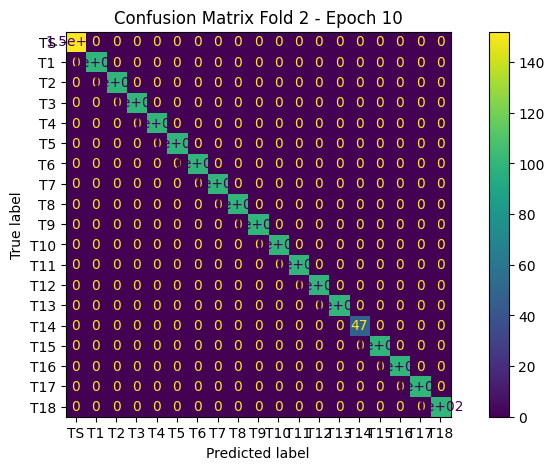

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,1.0,1.0,1.0,1.0
T1,100.0,1.0,1.0,1.0,1.0
T2,100.0,1.0,1.0,1.0,1.0
T3,100.0,1.0,1.0,1.0,1.0
T4,100.0,1.0,1.0,1.0,1.0
T5,100.0,1.0,1.0,1.0,1.0
T6,100.0,1.0,1.0,1.0,1.0
T7,100.0,1.0,1.0,1.0,1.0
T8,100.0,1.0,1.0,1.0,1.0
T9,100.0,1.0,1.0,1.0,1.0


1it [02:55, 120.34s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005300988910935952


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:00, 120.34s/it]

Average Loss Validation: 0.0005793283458236449
Time 5.091917514801025

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005457557454859807


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:05, 120.34s/it]

Average Loss Validation: 0.000588906132907141
Time 5.116082668304443

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004014115397106199


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:10, 120.34s/it]

Average Loss Validation: 0.0010081723625868714
Time 5.005626440048218

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:08, ?it/s]


Average Loss Train: 0.004184674981545203


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:19, 120.34s/it]

Average Loss Validation: 0.00043527244167004635
Time 8.980837106704712

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0035983819388314894


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 7.856599010362213e-05
Time 4.93779993057251



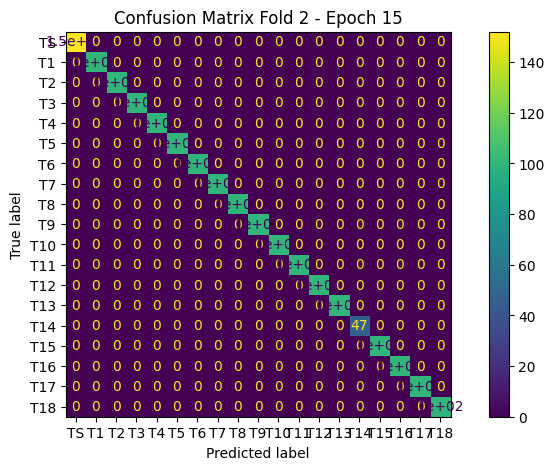

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,1.0,1.0,1.0,1.0
T1,100.0,1.0,1.0,1.0,1.0
T2,100.0,1.0,1.0,1.0,1.0
T3,100.0,1.0,1.0,1.0,1.0
T4,100.0,1.0,1.0,1.0,1.0
T5,100.0,1.0,1.0,1.0,1.0
T6,100.0,1.0,1.0,1.0,1.0
T7,100.0,1.0,1.0,1.0,1.0
T8,100.0,1.0,1.0,1.0,1.0
T9,100.0,1.0,1.0,1.0,1.0


1it [03:27, 120.34s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003352210172911824


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:32, 120.34s/it]

Average Loss Validation: 0.00029322665144112153
Time 5.030068397521973

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0045889627476180745


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:37, 120.34s/it]

Average Loss Validation: 0.00023439958728583104
Time 5.102064847946167

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0039363621656187155


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:42, 120.34s/it]

Average Loss Validation: 0.001223798188402725
Time 5.067453384399414

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003246309654518156


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
1it [03:47, 120.34s/it]

Average Loss Validation: 0.00019551855087532506
Time 5.137403726577759

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:07, ?it/s]


Average Loss Train: 0.003552137079153175


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0004759465572836537
Time 7.914004325866699



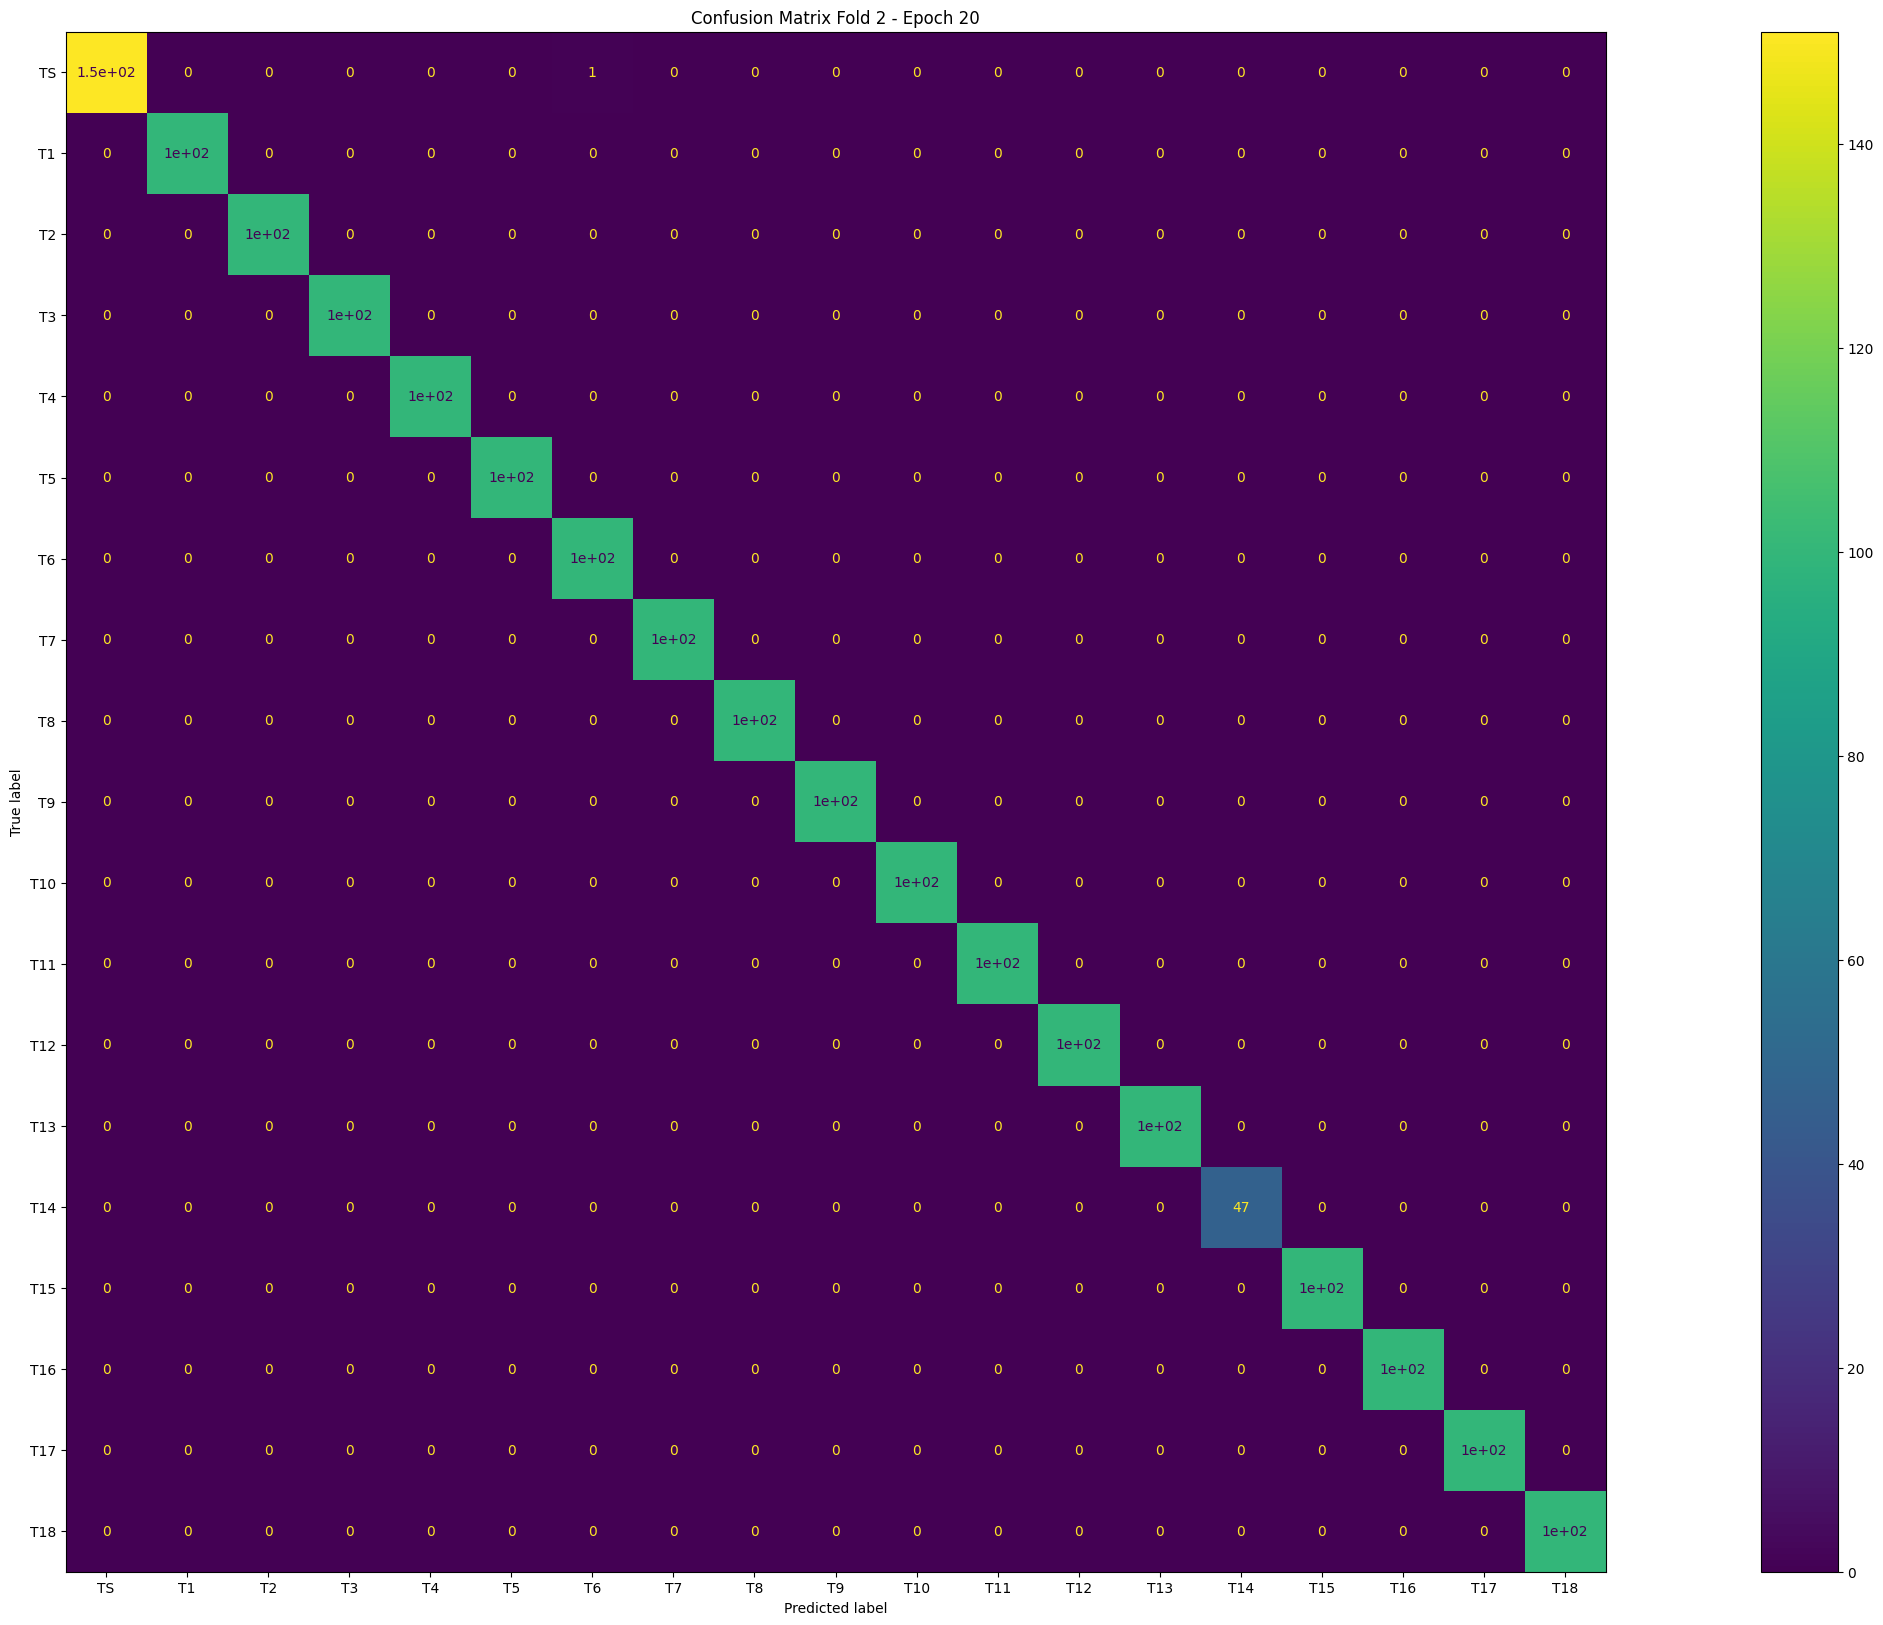

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.993421,1.000000,0.993421,0.996700
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,0.990099,1.000000,0.995025
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


100%|███████████████████████████████████████████| 20/20 [01:57<00:00,  5.89s/it]
2it [03:58, 118.95s/it]

=====:=====:=====:=====:===== Fold 3 =====:=====:=====:=====:=====
Fold 3 Ready


2it [03:58, 118.95s/it]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.044439433494723644


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:03, 118.95s/it]

Average Loss Validation: 0.00682439444353804
Time 5.004637956619263

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.012112818969444944


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:08, 118.95s/it]

Average Loss Validation: 0.0027524384602050605
Time 4.993671655654907

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.007330384340231158


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:13, 118.95s/it]

Average Loss Validation: 0.0020793931388955874
Time 5.031127691268921

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0069760173068092275


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:18, 118.95s/it]

Average Loss Validation: 0.0008445146479061805
Time 4.985414028167725

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.006526330107834754


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0012379440219471387
Time 4.971757411956787



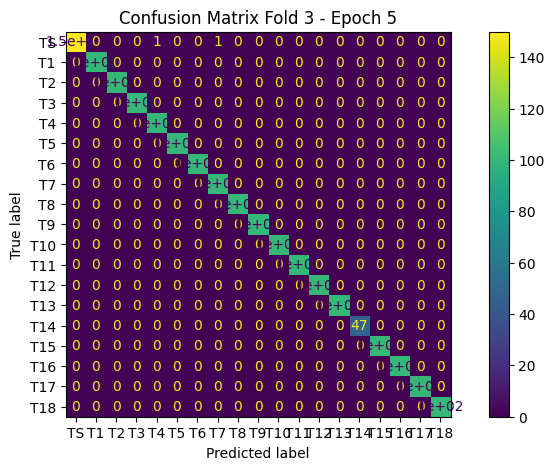

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.986842,1.000000,0.986842,0.993377
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,0.990099,1.000000,0.995025
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,0.990099,1.000000,0.995025
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


2it [04:25, 118.95s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.006202521024686636


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:30, 118.95s/it]

Average Loss Validation: 0.001043409010162577
Time 5.076627969741821

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:06, ?it/s]


Average Loss Train: 0.0053542160919178745


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:38, 118.95s/it]

Average Loss Validation: 0.000674393716568981
Time 7.402262926101685

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0038602879244497654


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:43, 118.95s/it]

Average Loss Validation: 0.000259676217562325
Time 4.986557960510254

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0053122671511309895


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [04:48, 118.95s/it]

Average Loss Validation: 0.0005299119127206116
Time 5.021142482757568

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005358709033530699


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.00032033922155581726
Time 5.003193616867065



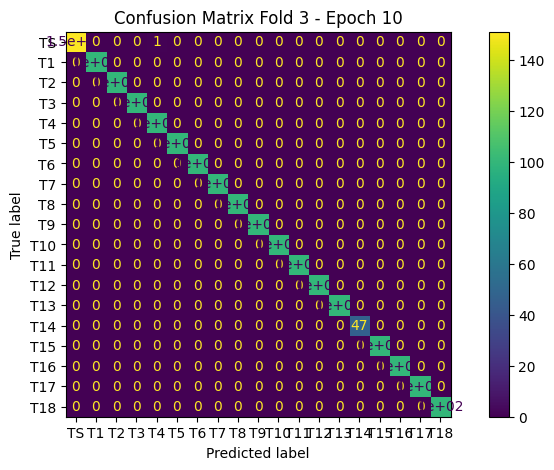

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.993421,1.000000,0.993421,0.996700
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,0.990099,1.000000,0.995025
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


2it [04:56, 118.95s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.00473871106695689


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:01, 118.95s/it]

Average Loss Validation: 0.0002311106077589405
Time 4.994437217712402

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004983519543424061


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:06, 118.95s/it]

Average Loss Validation: 0.00010641580781035979
Time 5.026297569274902

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004668133492051319


==:==:==Valid==:==:==: 0it [00:04, ?it/s]
2it [05:14, 118.95s/it]

Average Loss Validation: 0.0003288078801536661
Time 8.390317916870117

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003963455056210104


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:19, 118.95s/it]

Average Loss Validation: 8.358569963699362e-05
Time 5.450738906860352

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003534021898257906


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.00010262896254668401
Time 5.072620630264282



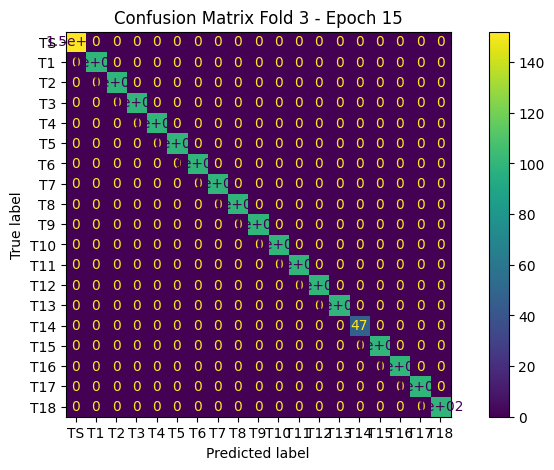

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,1.0,1.0,1.0,1.0
T1,100.0,1.0,1.0,1.0,1.0
T2,100.0,1.0,1.0,1.0,1.0
T3,100.0,1.0,1.0,1.0,1.0
T4,100.0,1.0,1.0,1.0,1.0
T5,100.0,1.0,1.0,1.0,1.0
T6,100.0,1.0,1.0,1.0,1.0
T7,100.0,1.0,1.0,1.0,1.0
T8,100.0,1.0,1.0,1.0,1.0
T9,100.0,1.0,1.0,1.0,1.0


2it [05:27, 118.95s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0034191826540153052


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:32, 118.95s/it]

Average Loss Validation: 0.0002479810456255412
Time 4.999081373214722

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003035938065937337


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:37, 118.95s/it]

Average Loss Validation: 0.0006799703430563871
Time 5.020158290863037

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004072964256920386


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:42, 118.95s/it]

Average Loss Validation: 6.084019432819332e-05
Time 5.070922374725342

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.001848272864433874


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
2it [05:47, 118.95s/it]

Average Loss Validation: 0.0006658605096769558
Time 4.988863706588745

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.00408305722497161


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 8.042629533520085e-05
Time 5.059356451034546



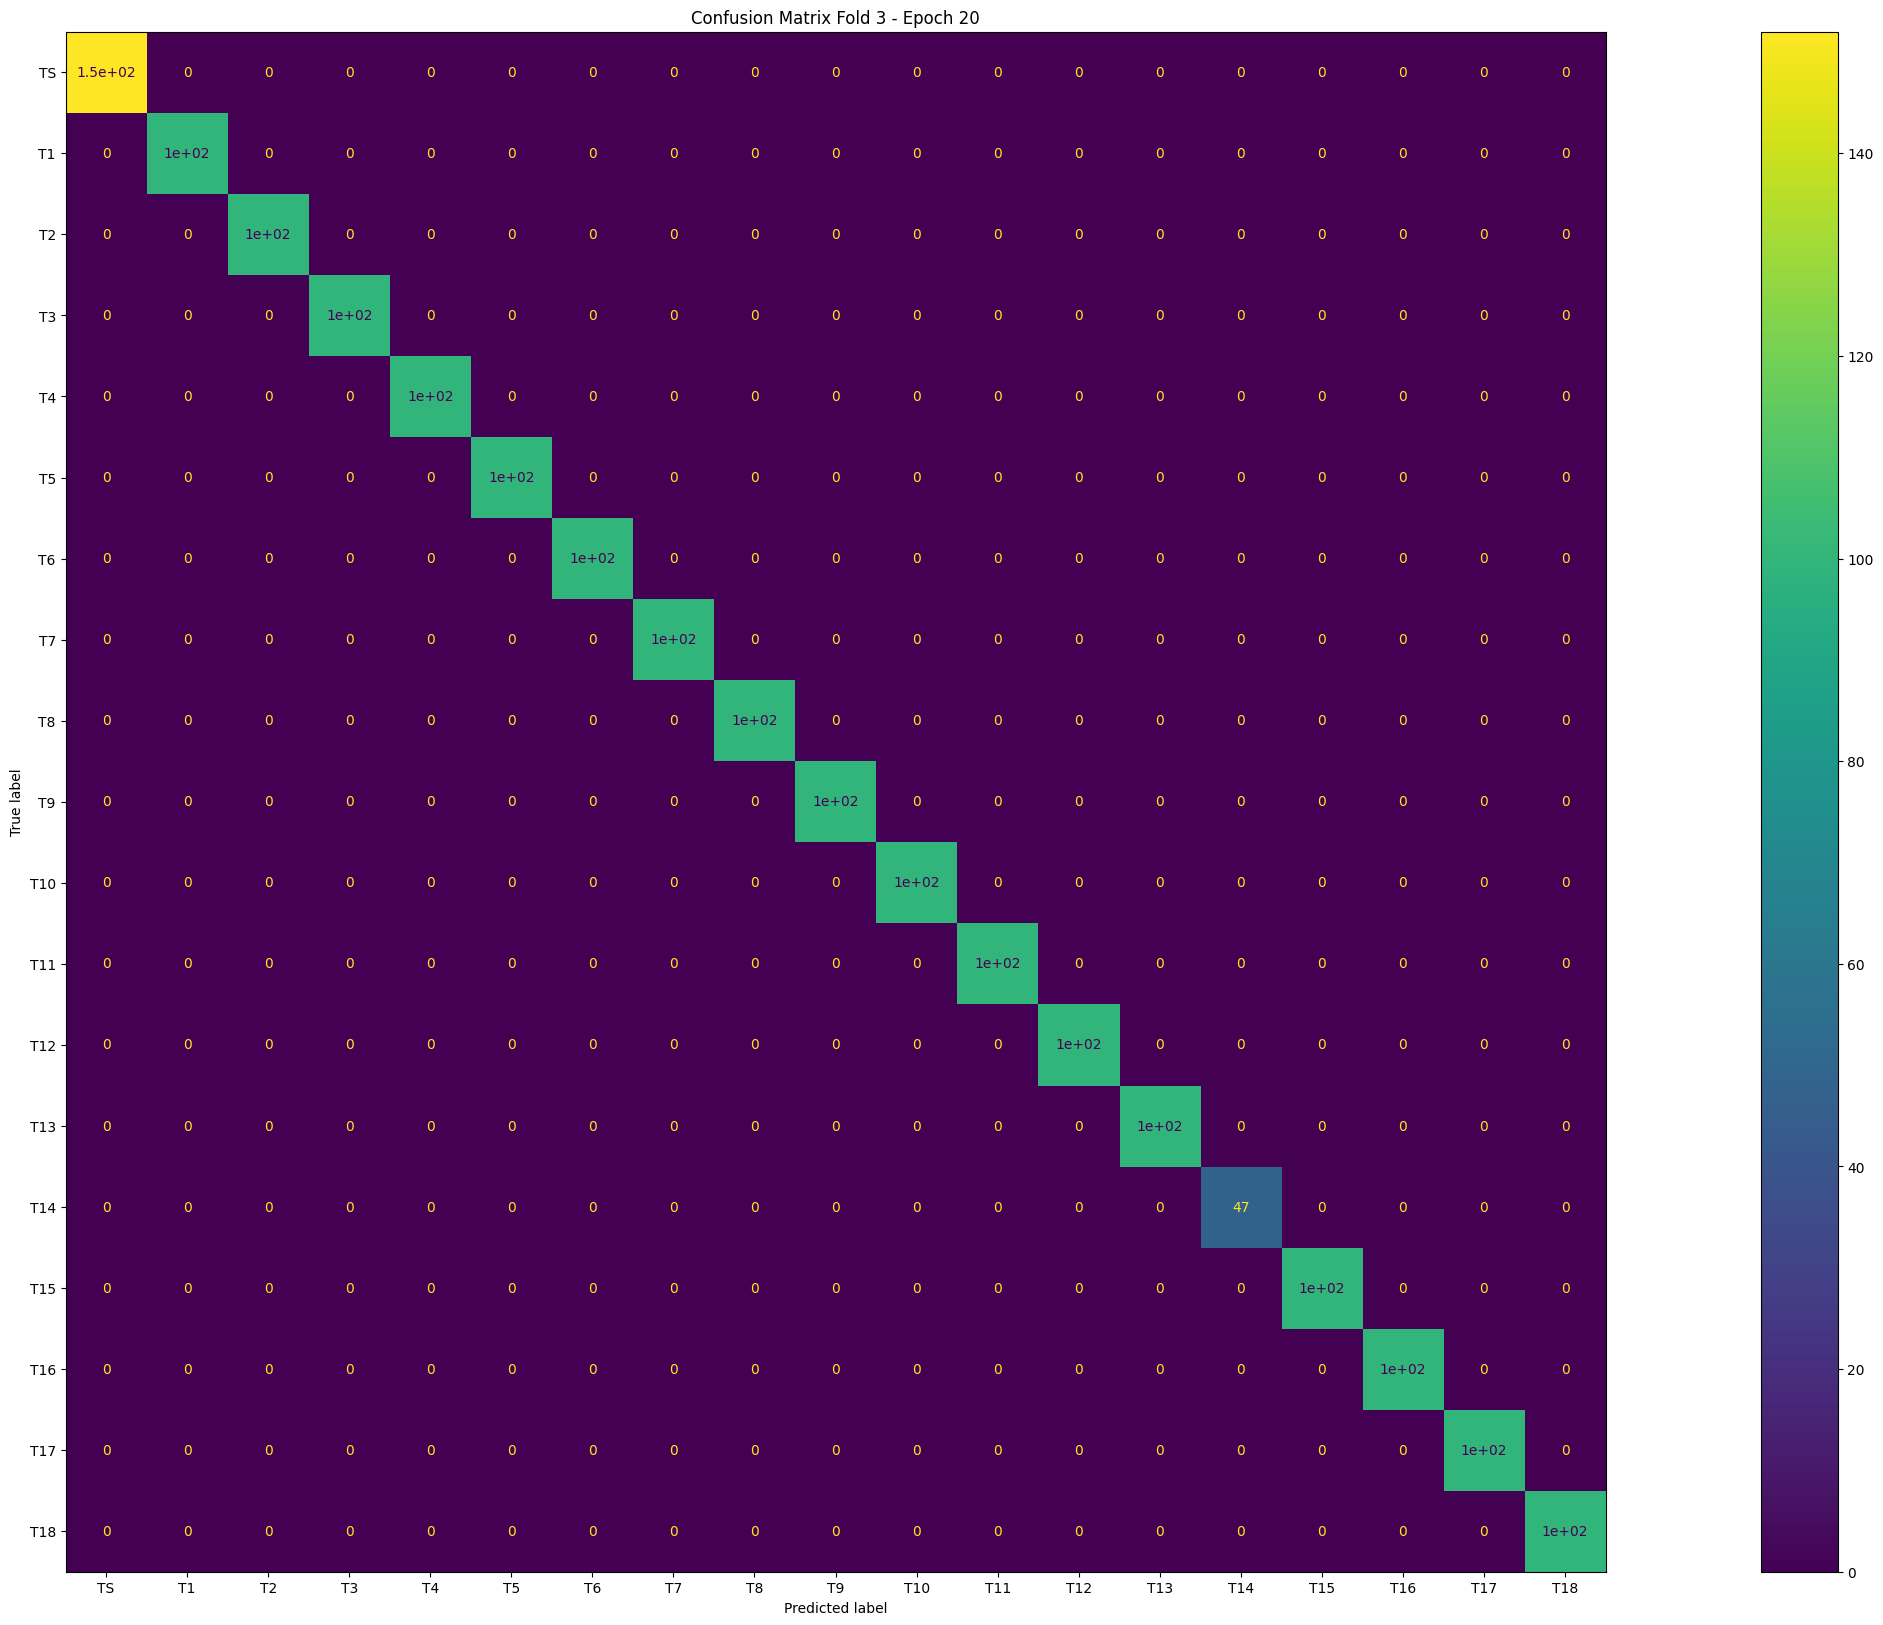

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,1.0,1.0,1.0,1.0
T1,100.0,1.0,1.0,1.0,1.0
T2,100.0,1.0,1.0,1.0,1.0
T3,100.0,1.0,1.0,1.0,1.0
T4,100.0,1.0,1.0,1.0,1.0
T5,100.0,1.0,1.0,1.0,1.0
T6,100.0,1.0,1.0,1.0,1.0
T7,100.0,1.0,1.0,1.0,1.0
T8,100.0,1.0,1.0,1.0,1.0
T9,100.0,1.0,1.0,1.0,1.0


100%|███████████████████████████████████████████| 20/20 [01:56<00:00,  5.84s/it]
3it [05:55, 118.06s/it]

=====:=====:=====:=====:===== Fold 4 =====:=====:=====:=====:=====
Fold 4 Ready


3it [05:55, 118.06s/it]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.04263497526686983


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:00, 118.06s/it]

Average Loss Validation: 0.01035766505713885
Time 4.954050064086914

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.01187115369419403


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:05, 118.06s/it]

Average Loss Validation: 0.007302137355630596
Time 5.017322778701782

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:07, ?it/s]


Average Loss Train: 0.009671351546617303


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:13, 118.06s/it]

Average Loss Validation: 0.00546513437681521
Time 8.27456521987915

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.006611109140892552


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:18, 118.06s/it]

Average Loss Validation: 0.004602067321926976
Time 4.900042533874512

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005313375118548567


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.005090435724074875
Time 4.926436901092529



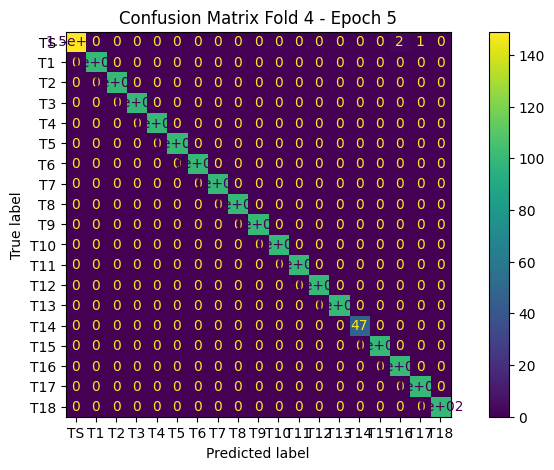

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.980263,1.000000,0.980263,0.990033
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


3it [06:26, 118.06s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005736762942930199


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:31, 118.06s/it]

Average Loss Validation: 0.003987201375760681
Time 5.117480278015137

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005494299256917825


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:36, 118.06s/it]

Average Loss Validation: 0.004651004883877856
Time 5.114691972732544

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0062987473563432


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:41, 118.06s/it]

Average Loss Validation: 0.003767201173468493
Time 5.177938222885132

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0055732179495228155


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [06:46, 118.06s/it]

Average Loss Validation: 0.003188863526035372
Time 5.105193138122559

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:05, ?it/s]


Average Loss Train: 0.0049052101796191626


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0030701291253838765
Time 6.799936771392822



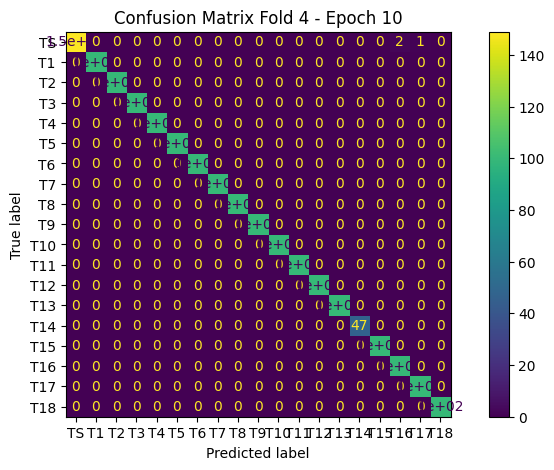

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.980263,1.000000,0.980263,0.990033
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


3it [06:55, 118.06s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004106923111395503


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:00, 118.06s/it]

Average Loss Validation: 0.0026927464688924372
Time 5.047840595245361

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003472175939006637


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:06, 118.06s/it]

Average Loss Validation: 0.004828407788348462
Time 5.026273727416992

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003763666674724639


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:11, 118.06s/it]

Average Loss Validation: 0.0037876616872381417
Time 4.99665093421936

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0076525803183855


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:16, 118.06s/it]

Average Loss Validation: 0.002961696251259127
Time 4.985545873641968

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005726273434149579


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0018490486285979084
Time 4.948970317840576



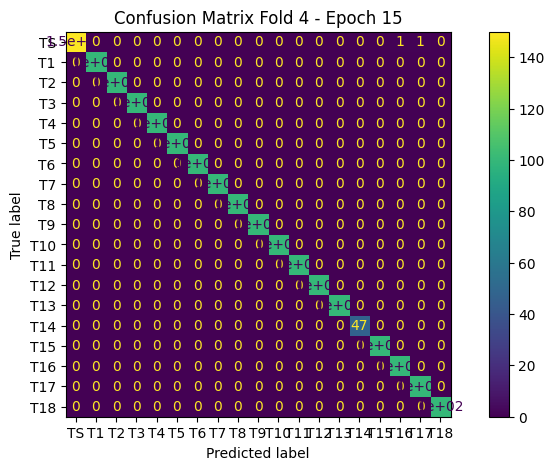

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.986842,1.000000,0.986842,0.993377
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


3it [07:23, 118.06s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0044443946420518335


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:28, 118.06s/it]

Average Loss Validation: 0.0031069482173431123
Time 5.049827814102173

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.002796212178784591


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:33, 118.06s/it]

Average Loss Validation: 0.00359844345014911
Time 4.990145444869995

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0029355563094229007


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:38, 118.06s/it]

Average Loss Validation: 0.0021331779382914346
Time 4.999224424362183

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005450400965106811


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
3it [07:43, 118.06s/it]

Average Loss Validation: 0.0018634159855234127
Time 5.002664804458618

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.006436738977135362


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0013629655428303521
Time 4.963906764984131



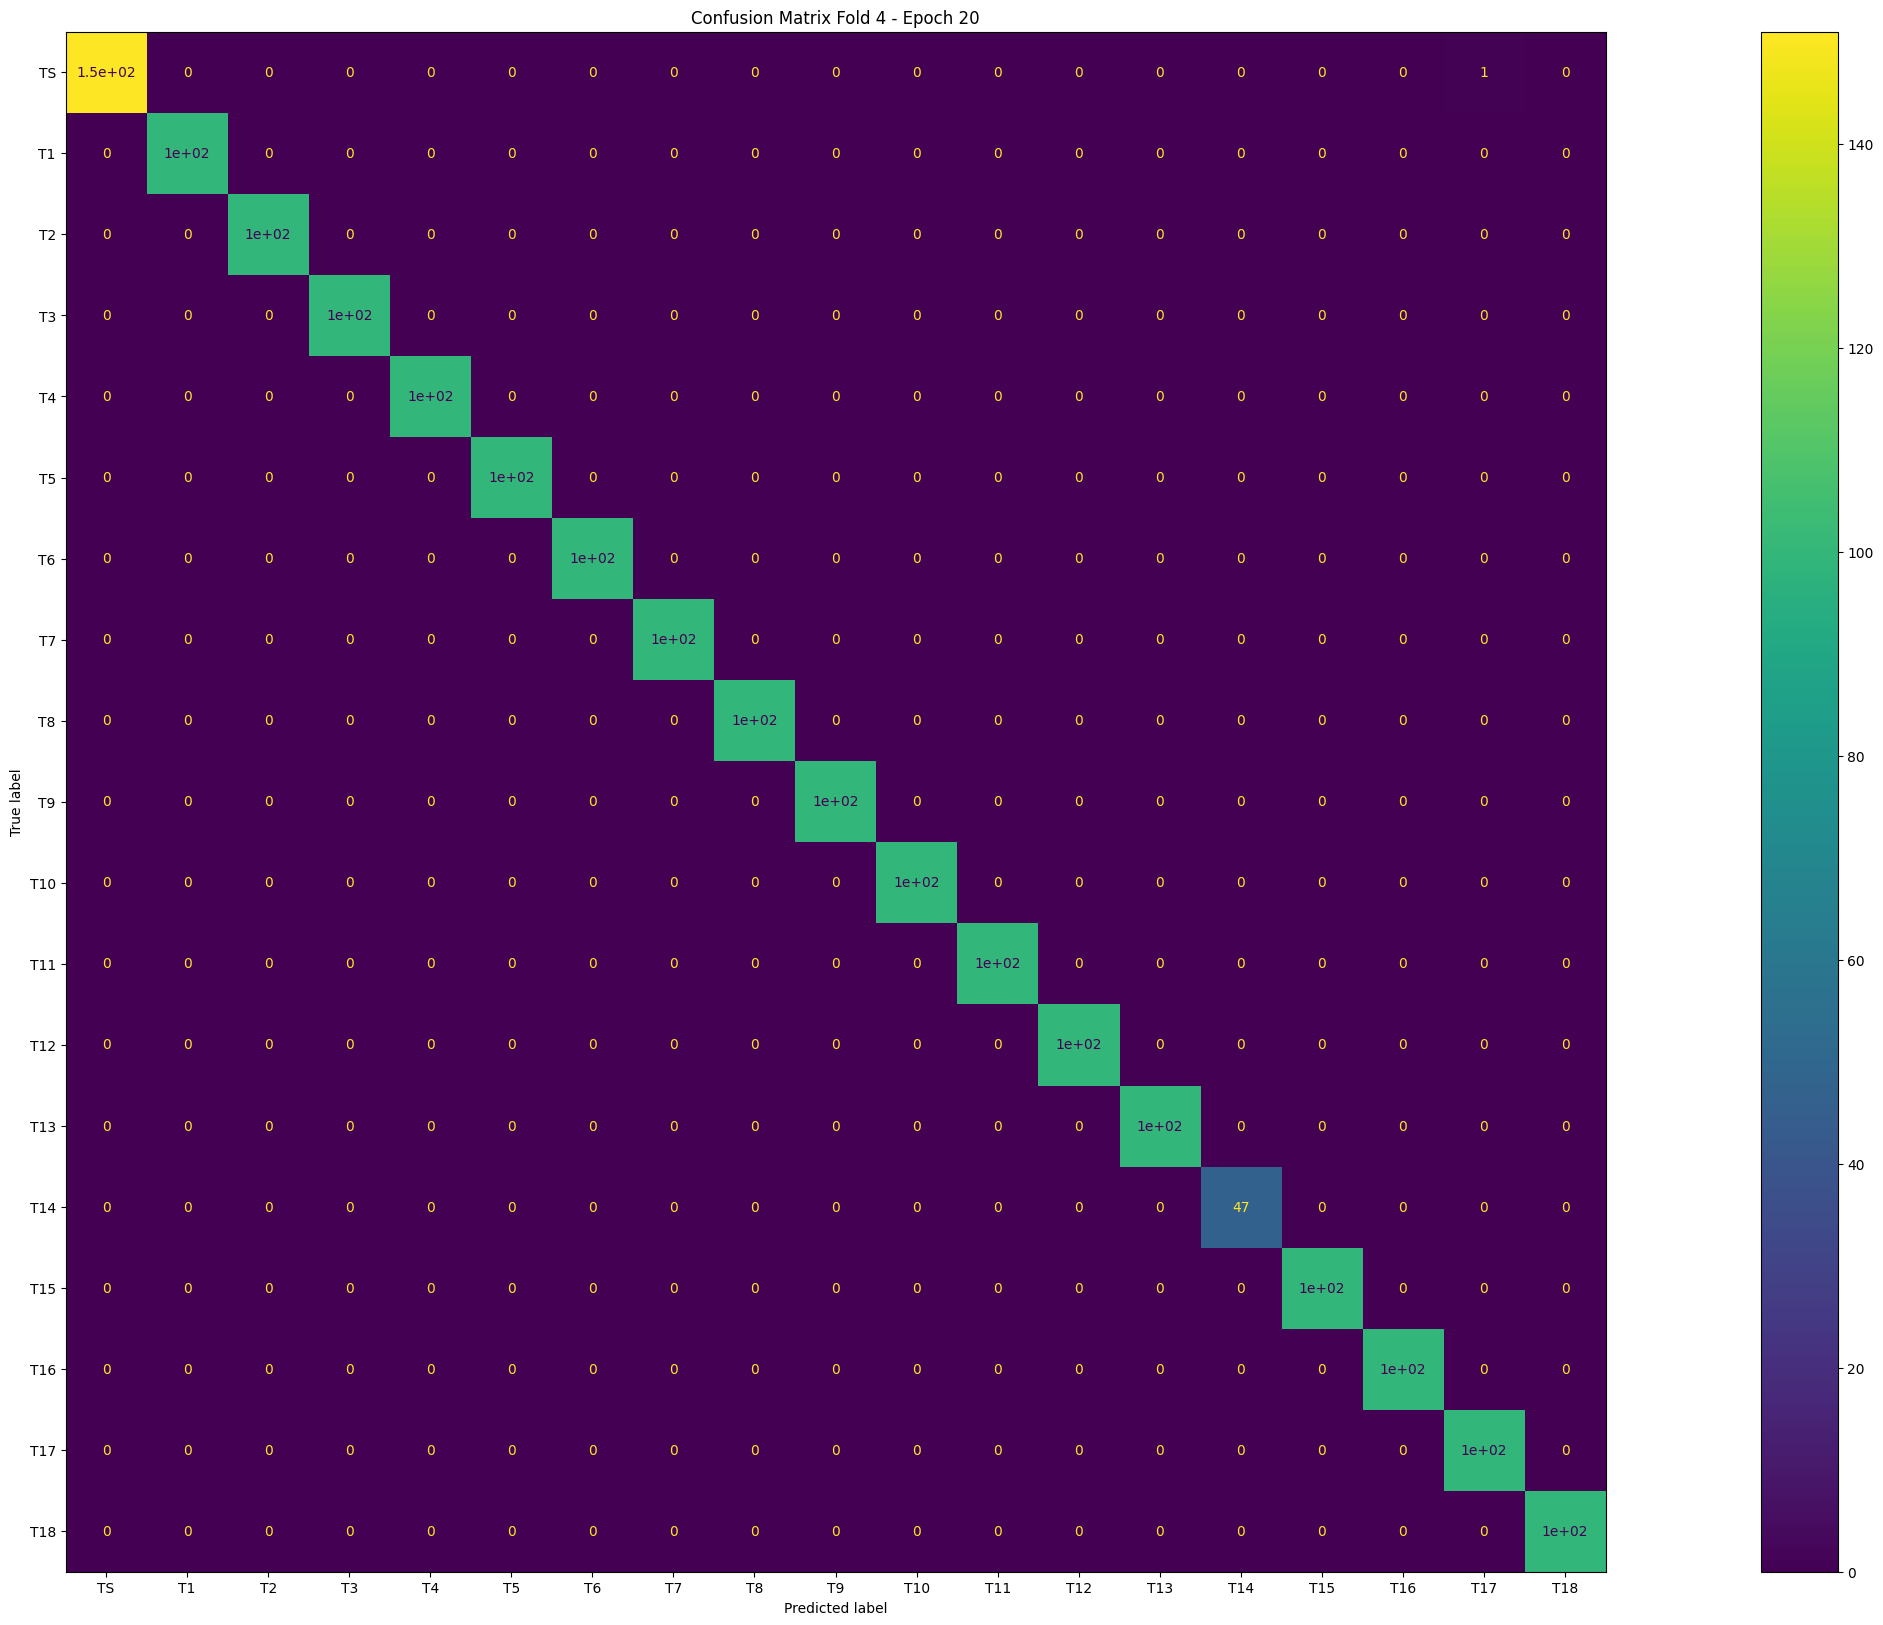

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.993421,1.000000,0.993421,0.996700
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,1.000000,1.000000,1.000000
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


100%|███████████████████████████████████████████| 20/20 [01:55<00:00,  5.80s/it]
4it [07:51, 117.28s/it]

=====:=====:=====:=====:===== Fold 5 =====:=====:=====:=====:=====
Fold 5 Ready


4it [07:51, 117.28s/it]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.04426947299062329


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [07:56, 117.28s/it]

Average Loss Validation: 0.010542101932999988
Time 5.027634859085083

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:06, ?it/s]


Average Loss Train: 0.012618286752322015


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:04, 117.28s/it]

Average Loss Validation: 0.009089148720765177
Time 7.495007276535034

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.009231351530218512


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:09, 117.28s/it]

Average Loss Validation: 0.005662106175926359
Time 4.966623306274414

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.007352193020687227


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:14, 117.28s/it]

Average Loss Validation: 0.0041766610491322355
Time 4.965824842453003

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.006521512332133667


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.004545147243576745
Time 4.951566457748413



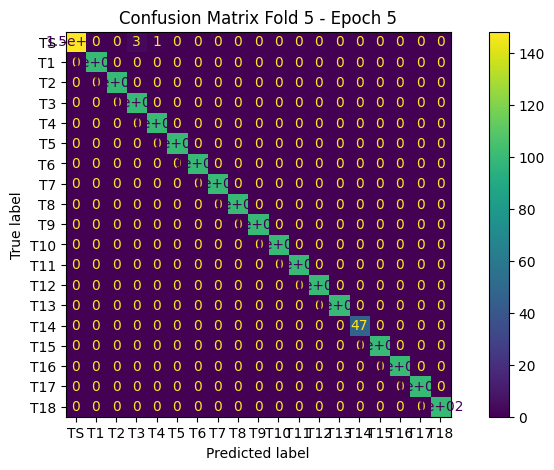

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.973684,1.000000,0.973684,0.986667
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,0.970874,1.000000,0.985222
T4,100.0,1.000000,0.990099,1.000000,0.995025
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


4it [08:21, 117.28s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005711936164195375


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:26, 117.28s/it]

Average Loss Validation: 0.004162216066955201
Time 5.0030436515808105

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0057822948866112925


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:31, 117.28s/it]

Average Loss Validation: 0.0014469451125478372
Time 4.9963719844818115

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.005515899478864833


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:36, 117.28s/it]

Average Loss Validation: 0.001330453934254668
Time 5.0103771686553955

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0047896567383828035


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:41, 117.28s/it]

Average Loss Validation: 0.0005212416451589282
Time 5.004804611206055

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004100633674093811


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0013531437686954936
Time 4.9780097007751465



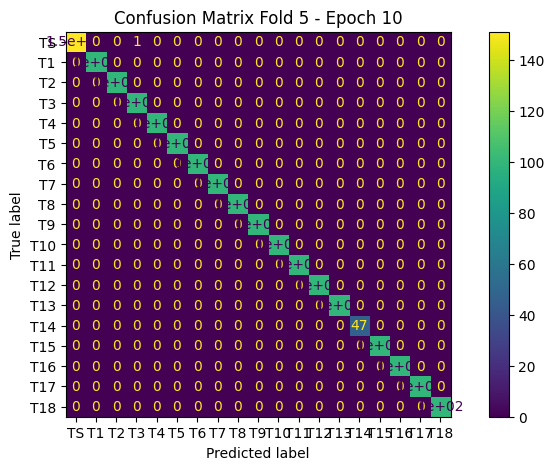

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.993421,1.000000,0.993421,0.996700
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,0.990099,1.000000,0.995025
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


4it [08:48, 117.28s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003723057958237756


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:53, 117.28s/it]

Average Loss Validation: 0.0009244832948752446
Time 5.040289640426636

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.00366557074662791


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [08:58, 117.28s/it]

Average Loss Validation: 0.0010901775850773751
Time 4.975752115249634

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004717567182799504


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:03, 117.28s/it]

Average Loss Validation: 0.00092991313085804
Time 4.993119955062866

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0028439054239693903


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:08, 117.28s/it]

Average Loss Validation: 0.0013777641749887456
Time 5.005800724029541

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0031608389721701053


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.0033592555458502225
Time 5.221376657485962



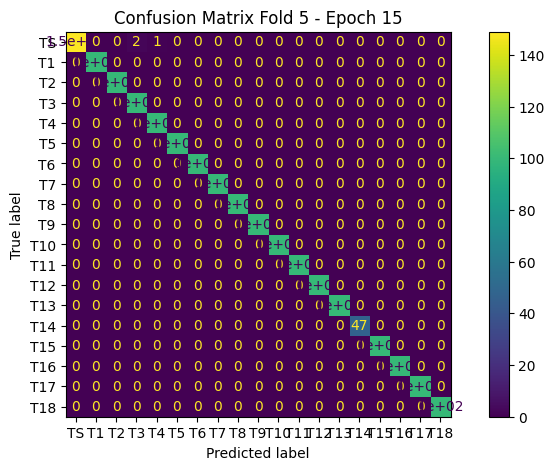

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.980263,1.000000,0.980263,0.990033
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,0.980392,1.000000,0.990099
T4,100.0,1.000000,0.990099,1.000000,0.995025
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


4it [09:16, 117.28s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.004641752815602382


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:21, 117.28s/it]

Average Loss Validation: 0.0018151828363746367
Time 5.0874223709106445

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.0017434383808300603


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:26, 117.28s/it]

Average Loss Validation: 0.0017148459991100631
Time 5.130908489227295

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.003923859054644831


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:32, 117.28s/it]

Average Loss Validation: 0.0015153697101898918
Time 5.1259565353393555

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.00534445729147997


==:==:==Valid==:==:==: 0it [00:00, ?it/s]
4it [09:37, 117.28s/it]

Average Loss Validation: 0.002545601520493316
Time 5.024624824523926

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:04, ?it/s]


Average Loss Train: 0.00295180769495621


==:==:==Valid==:==:==: 0it [00:00, ?it/s]


Average Loss Validation: 0.001954075010265418
Time 4.979158401489258



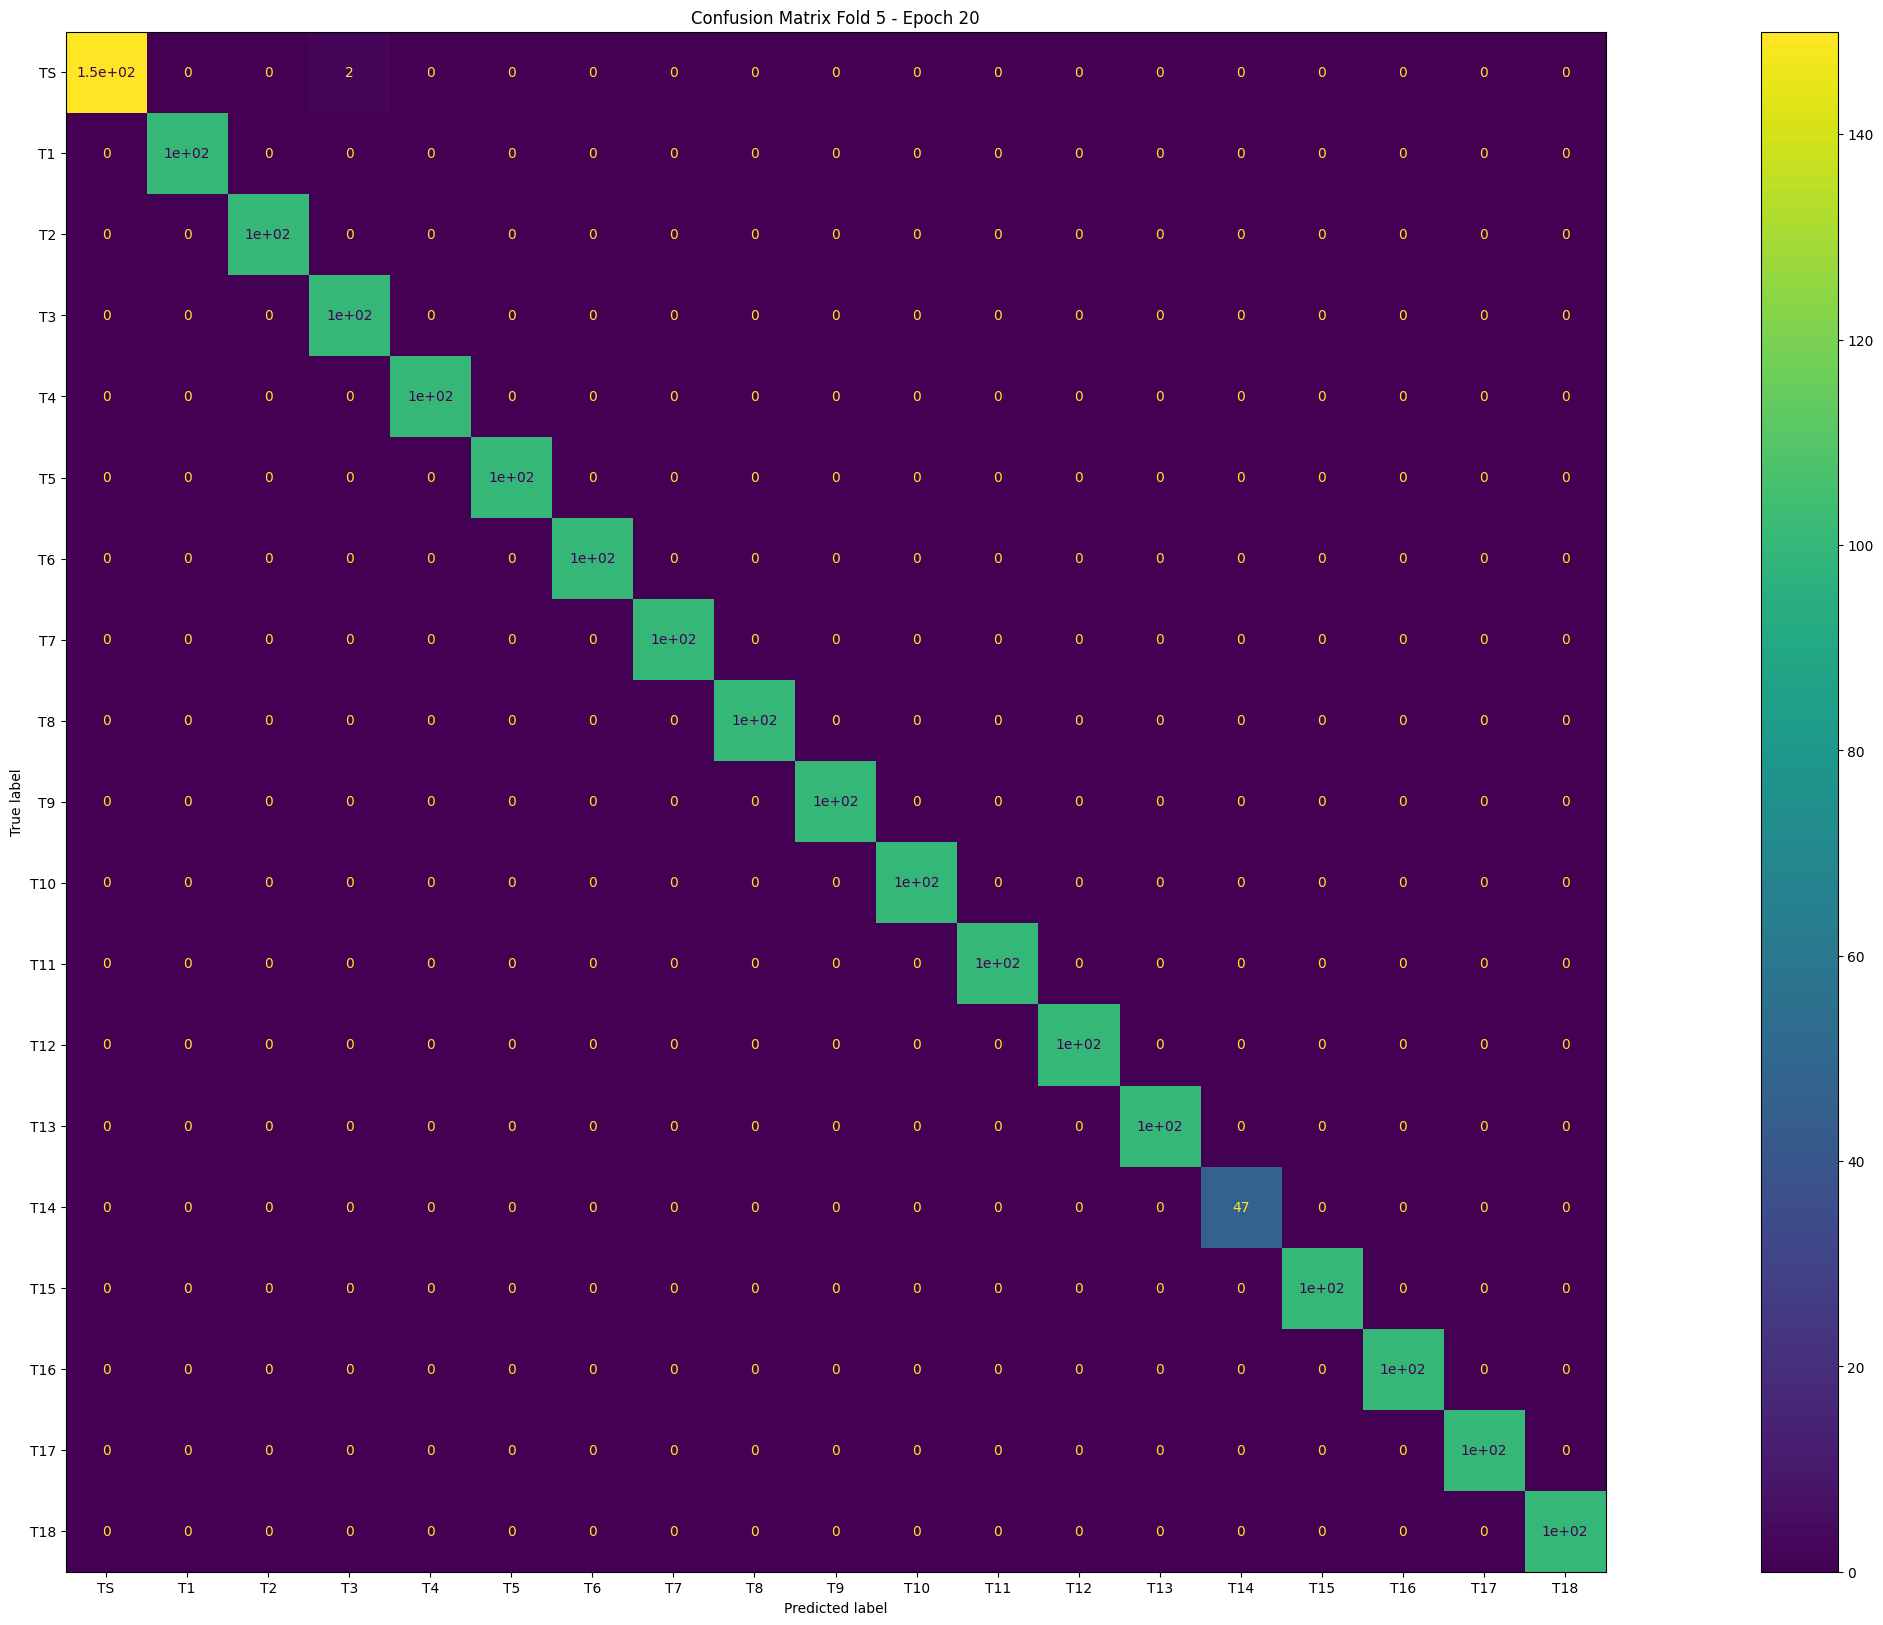

,Amount of Data,Accuracy,Precision,Recall,F One
TS,152.0,0.986842,1.000000,0.986842,0.993377
T1,100.0,1.000000,1.000000,1.000000,1.000000
T2,100.0,1.000000,1.000000,1.000000,1.000000
T3,100.0,1.000000,0.980392,1.000000,0.990099
T4,100.0,1.000000,1.000000,1.000000,1.000000
T5,100.0,1.000000,1.000000,1.000000,1.000000
T6,100.0,1.000000,1.000000,1.000000,1.000000
T7,100.0,1.000000,1.000000,1.000000,1.000000
T8,100.0,1.000000,1.000000,1.000000,1.000000
T9,100.0,1.000000,1.000000,1.000000,1.000000


100%|███████████████████████████████████████████| 20/20 [01:53<00:00,  5.67s/it]
5it [09:45, 117.00s/it]


In [50]:
import time
torch.manual_seed(12345)

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 20

model.to(DEVICE)

training_losses = [[] for i in range(5)]
validation_losses = [[] for i in range(5)]

skf = StratifiedKFold(n_splits=5)
kf = KFold(n_splits=5)

# Load before training + validing
for fold_i, (train_index, val_index) in enumerate(tqdm(skf.split(np.zeros(len(qa_dataset_train)), data_train_label), position=0, leave=True)):
  tqdm.write(f"=====:=====:=====:=====:===== Fold {fold_i + 1} =====:=====:=====:=====:=====")

  # Subset dataset for train and val
  train_dataset = Subset(qa_dataset_train, train_index)
  valid_dataset = Subset(qa_dataset_train, val_index)

  # train_semantic_dataset = Subset(qa_dataset_train_semantic, train_semantic_index)
  # valid_semantic_dataset = Subset(qa_dataset_train_semantic, val_semantic_index)

  train_size = len(train_dataset)
  valid_size = len(valid_dataset)
  # train_semantic_size = len(train_semantic_dataset)
  # valid_semantic_size = len(valid_semantic_dataset)

  train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  # train_semantic_instances = DataLoader(train_semantic_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  # valid_semantic_instances = DataLoader(valid_semantic_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  save_path = 'model/class/'
  model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

  bert_class = torch.load(model_class_path)
  model = BERT_Lexidqa2_class(bert_class.bert, 768, 19)
  with torch.no_grad():
    model.linear1.weight[:] = bert_class.linear1.weight.data.clone()
    model.linear2.weight[1:20] = bert_class.linear2.weight.data.clone()
  model.to(DEVICE)

  # optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

  tqdm.write(f'Fold {fold_i + 1} Ready')

  for epoch_i in tqdm(range(0, EPOCH), position=0, leave=True):
    start = time.time()
    tqdm.write(f"Epoch {epoch_i + 1} / {EPOCH}")

    # Freeze all layers and fcl
    for param in model.parameters():
        param.requires_grad = False
    for param in model.bert.encoder.layer[11].parameters():
        param.requires_grad = True
    for param in model.linear1.parameters():
        param.requires_grad = True
    for param in model.linear2.parameters():
      param.requires_grad = True

    # Reset the total loss for this epoch.
    tr_loss = 0

    # Put the model into training mode.
    model.train()

    # Untuk setiap data di training data
    train_total_data = 0
    train_pbar = tqdm(desc="==:==:==Train==:==:==", position=0, leave=True)
    for data in train_instances:

      # Mendapatkan output dari model
      train_total_data += len(data)


      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # Agar gradient tidak menumpuk; ini diperlukan sebelum
      # menghitung gradient dengan loss.backward()
      optimizer.zero_grad()

      # hitung gradient
      loss.backward()

      # update parameter
      optimizer.step()

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      # train_pbar.update(len(data))

    # rata-rata loss dalam 1 epoch
    avg_loss = tr_loss / train_total_data

    training_losses[fold_i].append(avg_loss)

    train_pbar.write(f"Average Loss Train: {avg_loss}")

    train_pbar.close()

    ### Uji coba di Validation Data

    # model eval, agar layer seperti dropout yang menghasilkan
    # sesuai yang random tidak digunakan
    model.eval()

    val_loss = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    valid_total_data = 0
    valid_pbar = tqdm(desc="==:==:==Valid==:==:==", position=0, leave=True)
    for data in valid_instances:

      # jangan track gradient! ini sedang evaluasi, bukan training
      with torch.no_grad():

        valid_total_data += len(data)

        # Mendapatkan output dari model
        input, gold = data
        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)

        # Categorical Cross-Entropy --- Loss Function
        loss = loss_func(pred, gold)

        # akumulasi loss di validation set
        val_loss += loss.item()

        # valid_pbar.update(len(data))


    # average loss
    avg_val_loss = val_loss / valid_total_data

    validation_losses[fold_i].append(avg_val_loss)

    valid_pbar.write(f"Average Loss Validation: {avg_val_loss}")

    end = time.time()
    valid_pbar.write("Time " + str(end-start))
    valid_pbar.write("")
    valid_pbar.close()

    # accuracy
    # pred_labels = torch.stack(pred_labels).numpy()
    # true_labels = torch.stack(true_labels).numpy()
    # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
    # print(f"Accuracy di validation data: {val_accuracy}")


    if (epoch_i + 1) % 5 == 0:
      nb_classes = 19

      conf_matrix = torch.zeros(nb_classes, nb_classes)
      with torch.no_grad():
        for i, (input, gold) in enumerate(valid_instances):
          input = input.to(DEVICE)
          gold = gold.to(DEVICE)
          pred = model(input)
          # _, gold = torch.max(gold, 1)
          # _, pred = torch.max(pred, 1)
          # for t, p in zip(gold.view(-1), pred.view(-1)):
          #   conf_matrix[t.long(), p.long()] += 1

          conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
      data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }


      fig, ax = _, _
      if (epoch_i + 1) != EPOCH:
        fig, ax = plt.subplots(figsize=(10, 5))
      else:
        fig, ax = plt.subplots(figsize=(40, 20))

      display_labels = ['TS', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
      disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
      disp.plot(ax=ax)
      plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch {epoch_i + 1}")
      plt.show()

      disp_df = pd.DataFrame(data=data_conf,
                            index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
      display(disp_df)

      # for i, template_index in enumerate(display_labels):
      #   print(f"Evaluation for {template_index}:")
      #   print(f"Amount of Data: {amt[i]}")
      #   print(f"Accuracy: {acc[i]}")
      #   print(f"Precision: {prec[i]}")
      #   print(f"Recall: {rec[i]}")
      #   print(f"F One: {f1[i]}")
      #   print()

      model.to("cpu")

      save_path = 'model_semantic/class_checkpoint/fold_' + str(fold_i)
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      model_class_path = os.path.join(save_path, "indobert_class_semantic_checkpoint_" + str(epoch_i) +".pth")
      torch.save(model, model_class_path)

      model.to(DEVICE)

### Visualize

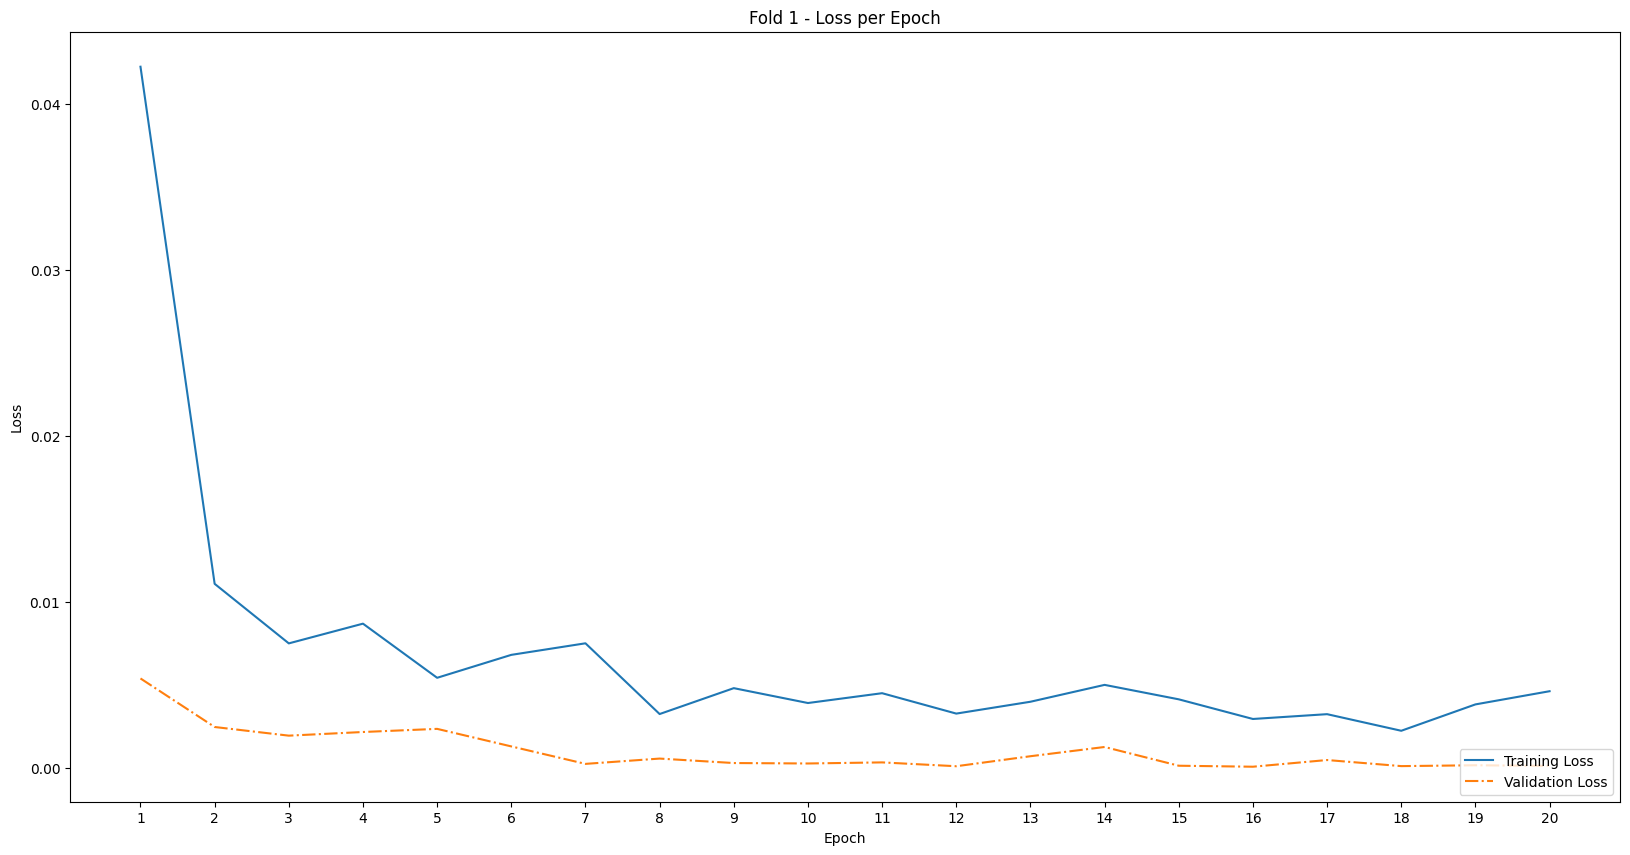

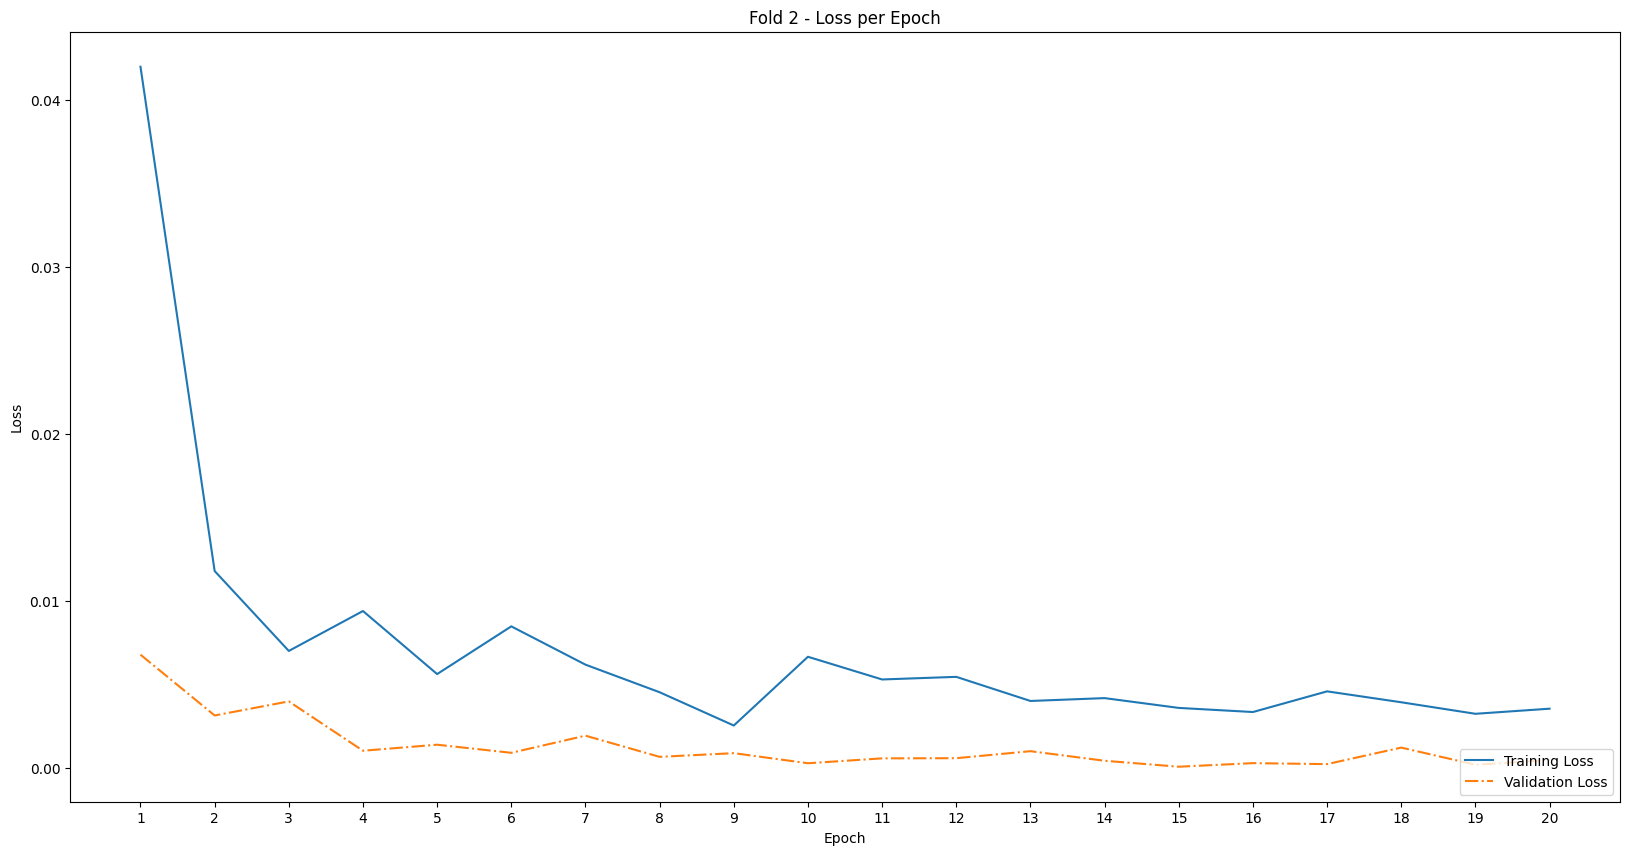

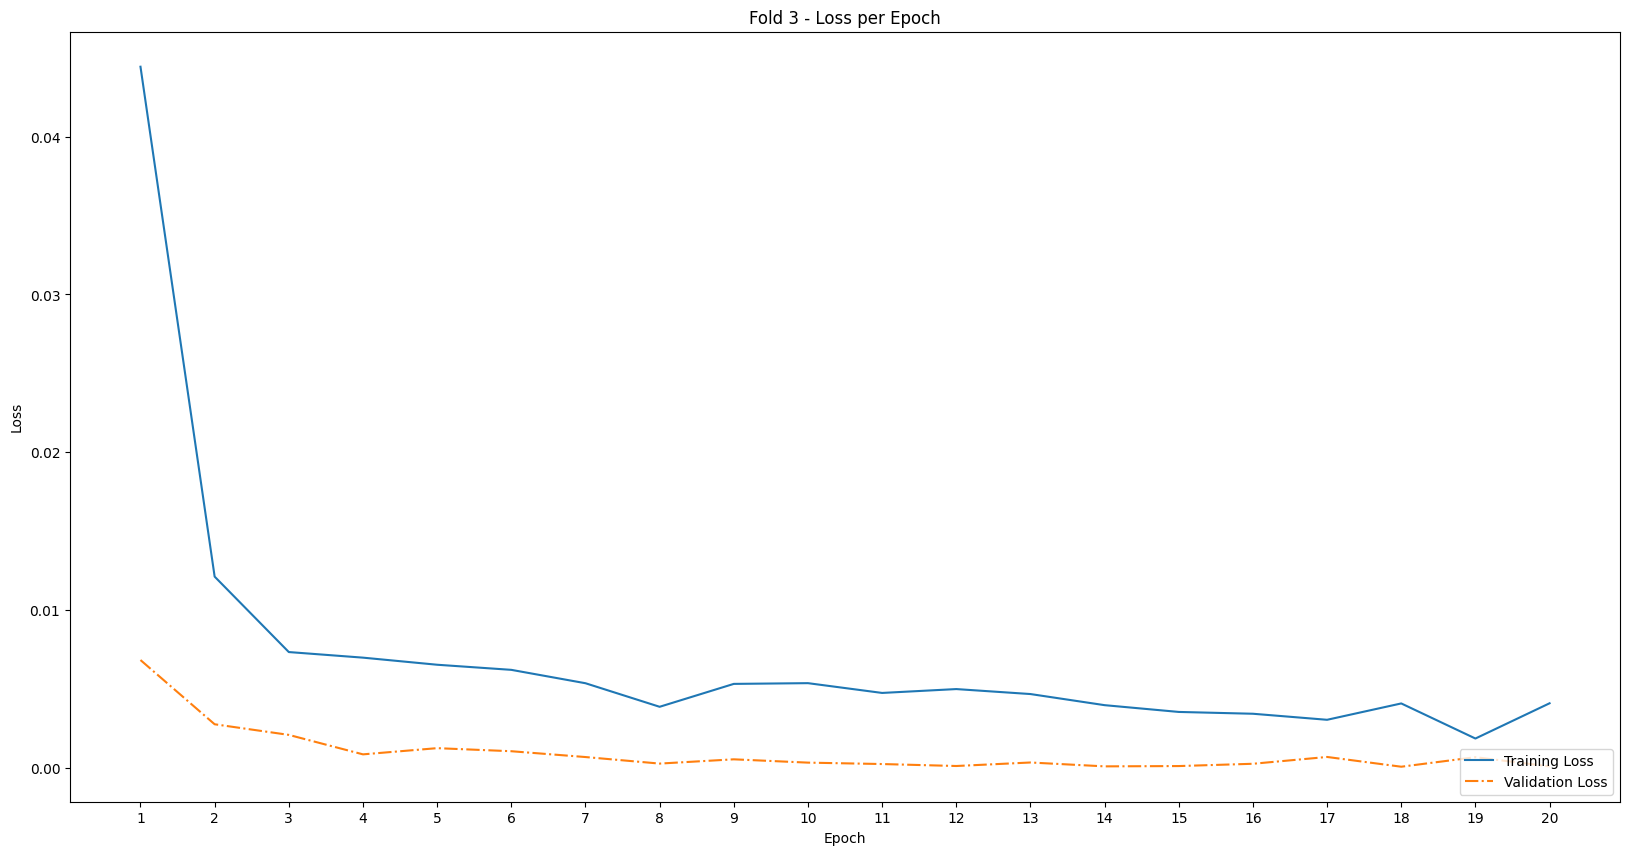

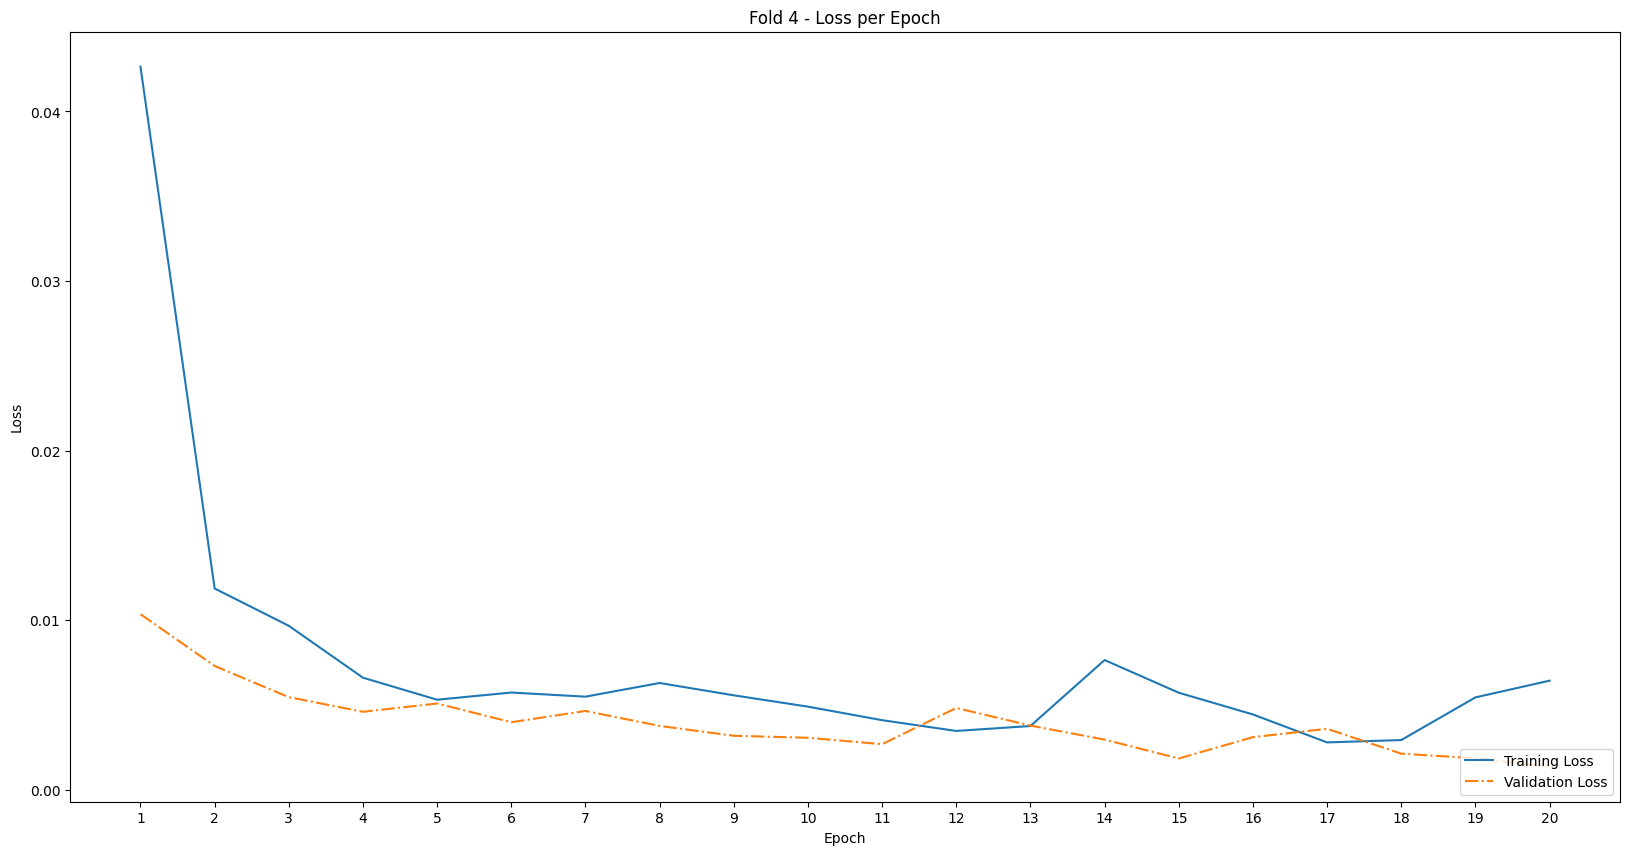

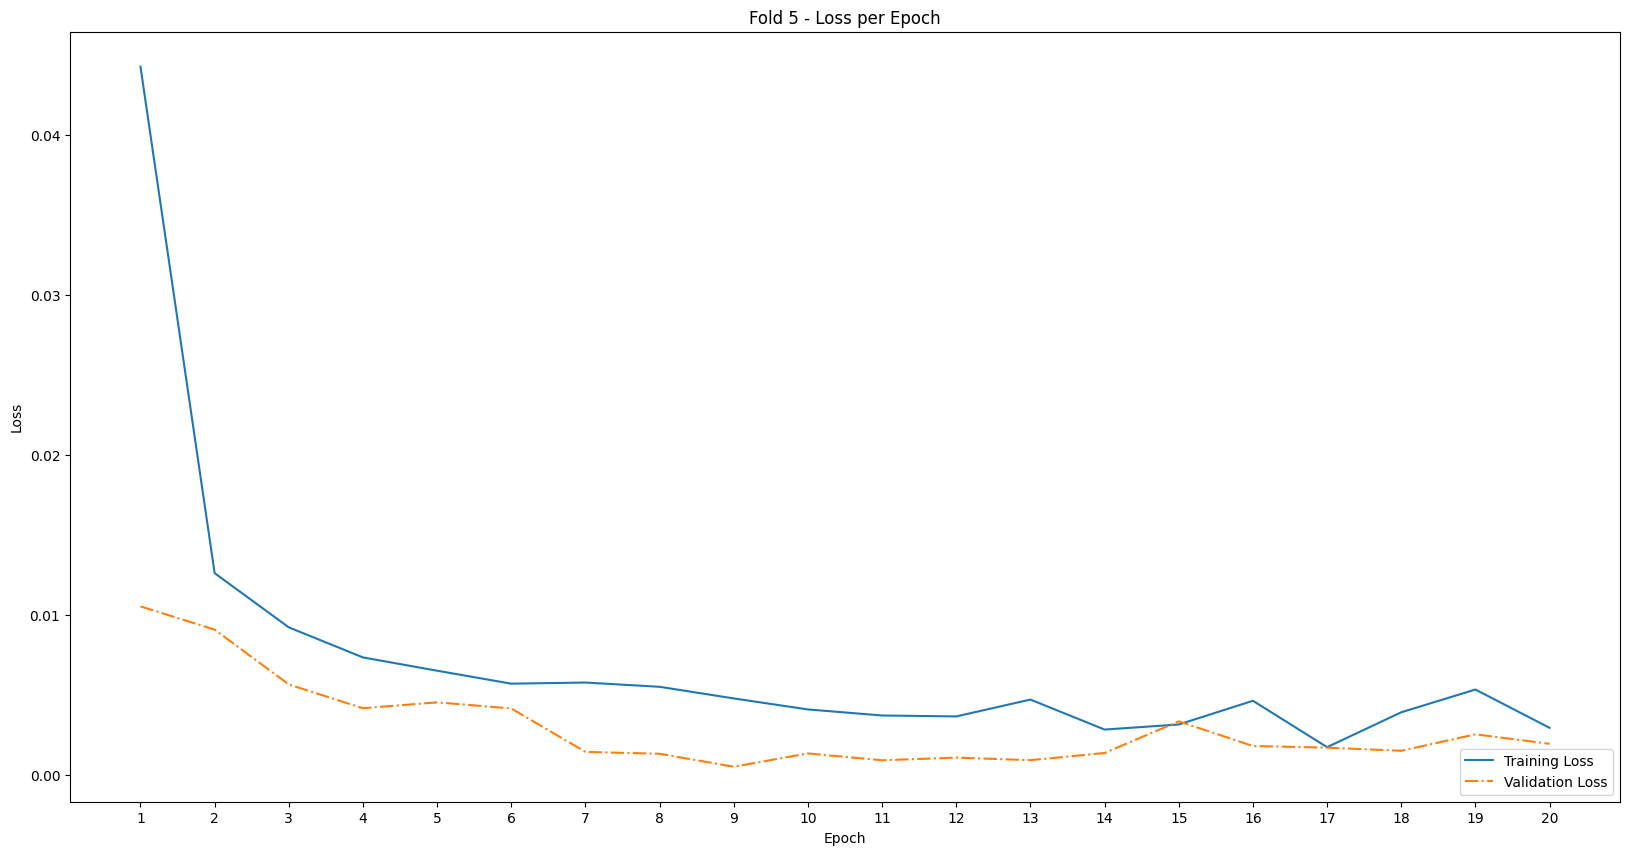

In [51]:
for i in range(5):
  x = np.arange(1, 21)
  y_train_loss = np.asarray(training_losses[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_losses[i], dtype=np.float32)

  plt.figure(figsize=(20,10))

  plt.plot(x, y_train_loss[0:20])
  plt.plot(x, y_val_loss[0:20], '-.')

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'Fold {i + 1} - Loss per Epoch')
  plt.show()

### Save Model

In [ ]:
# save_path = 'model/class/'
# !mkdir -p model/class/

# model_class_path = os.path.join(save_path, "indobert_class_tesaurus"+".pth")

# model.to('cpu')
# torch.save(model, model_class_path)

## Test


Average loss di testing data: 5.367280289241857e-06


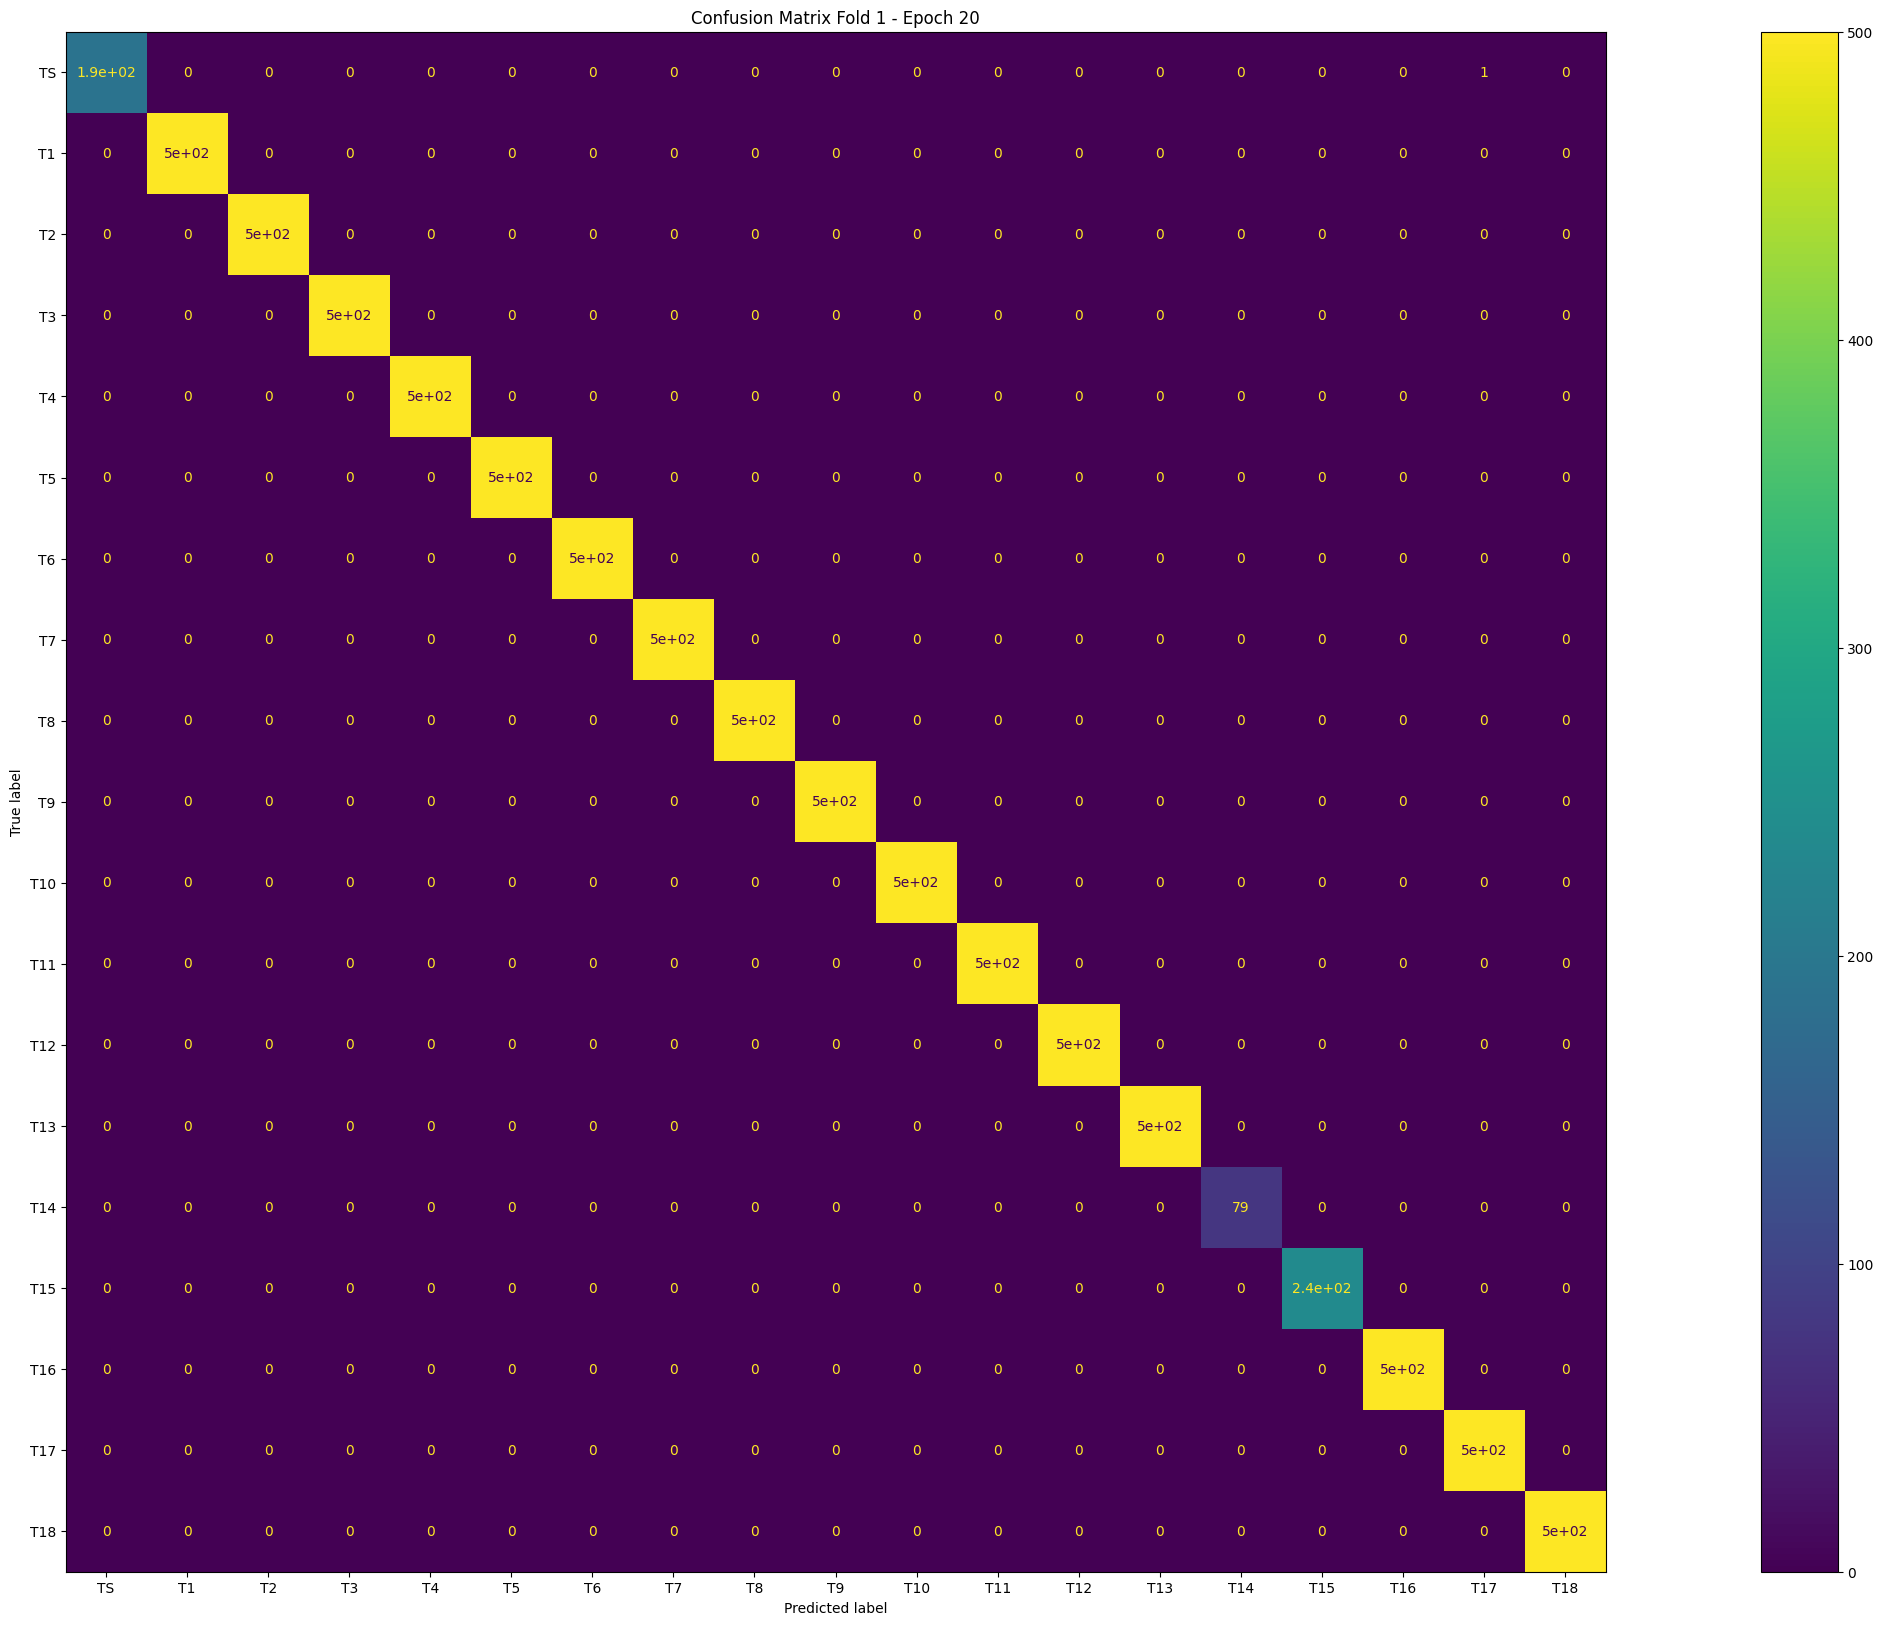

,Amount of Data,Accuracy,Precision,Recall,F One
TS,191.0,0.994764,1.000000,0.994764,0.997375
T1,500.0,1.000000,1.000000,1.000000,1.000000
T2,500.0,1.000000,1.000000,1.000000,1.000000
T3,500.0,1.000000,1.000000,1.000000,1.000000
T4,500.0,1.000000,1.000000,1.000000,1.000000
T5,500.0,1.000000,1.000000,1.000000,1.000000
T6,500.0,1.000000,1.000000,1.000000,1.000000
T7,500.0,1.000000,1.000000,1.000000,1.000000
T8,500.0,1.000000,1.000000,1.000000,1.000000
T9,500.0,1.000000,1.000000,1.000000,1.000000



Average loss di testing data: 2.1189929725805193e-05


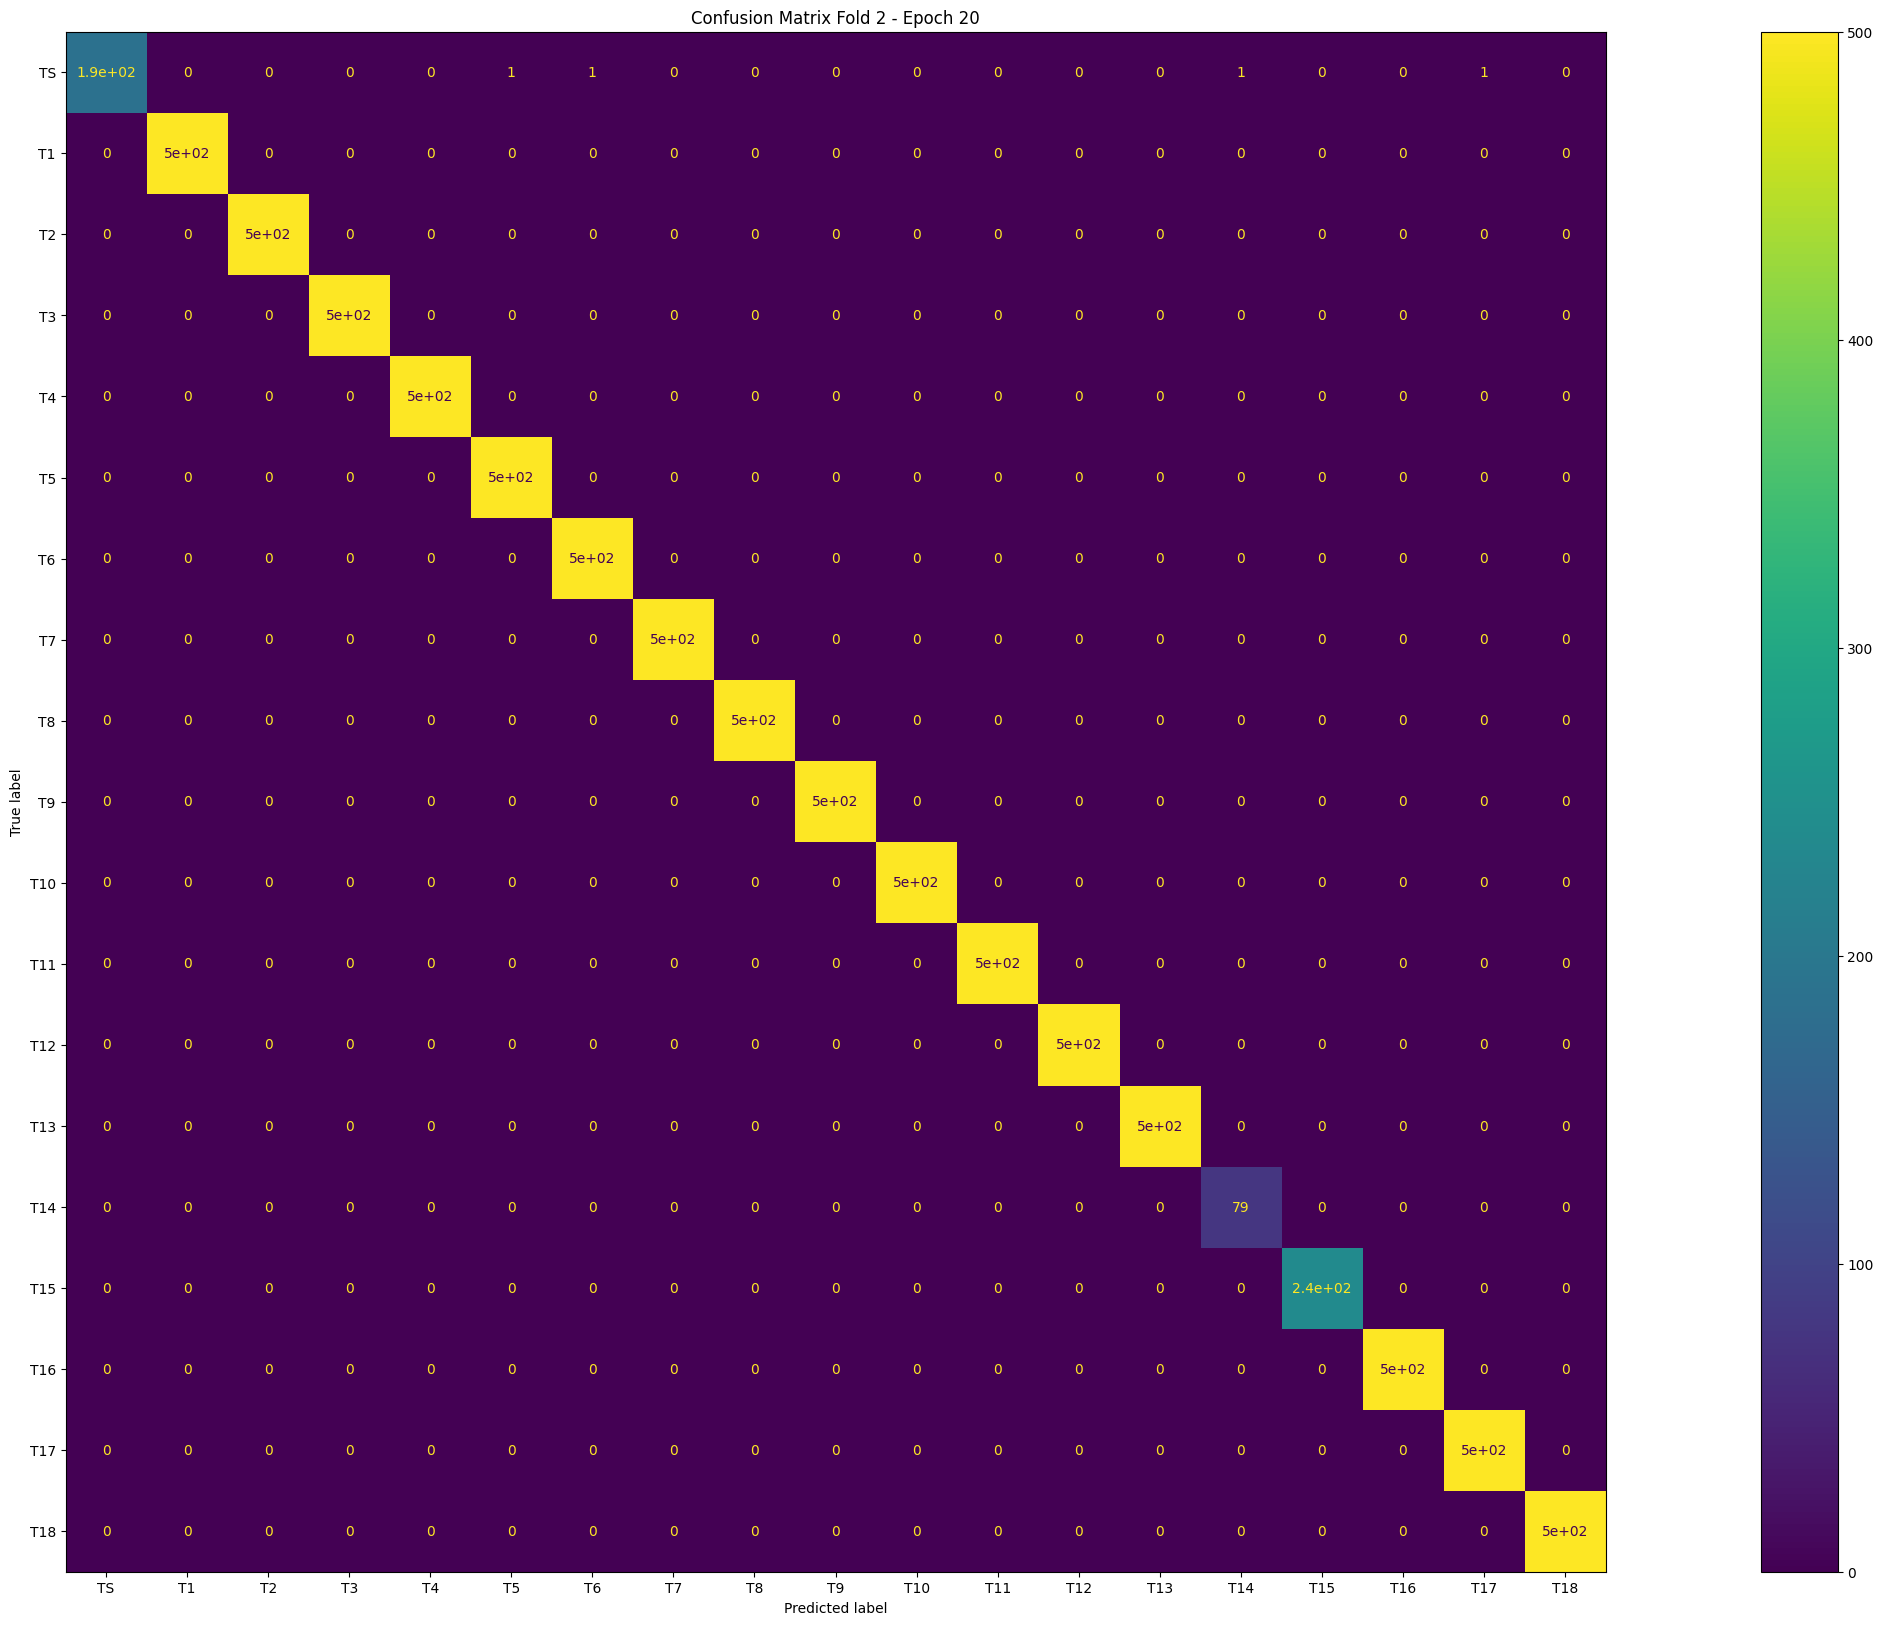

,Amount of Data,Accuracy,Precision,Recall,F One
TS,191.0,0.979058,1.000000,0.979058,0.989418
T1,500.0,1.000000,1.000000,1.000000,1.000000
T2,500.0,1.000000,1.000000,1.000000,1.000000
T3,500.0,1.000000,1.000000,1.000000,1.000000
T4,500.0,1.000000,1.000000,1.000000,1.000000
T5,500.0,1.000000,0.998004,1.000000,0.999001
T6,500.0,1.000000,0.998004,1.000000,0.999001
T7,500.0,1.000000,1.000000,1.000000,1.000000
T8,500.0,1.000000,1.000000,1.000000,1.000000
T9,500.0,1.000000,1.000000,1.000000,1.000000



Average loss di testing data: 4.951109041228424e-06


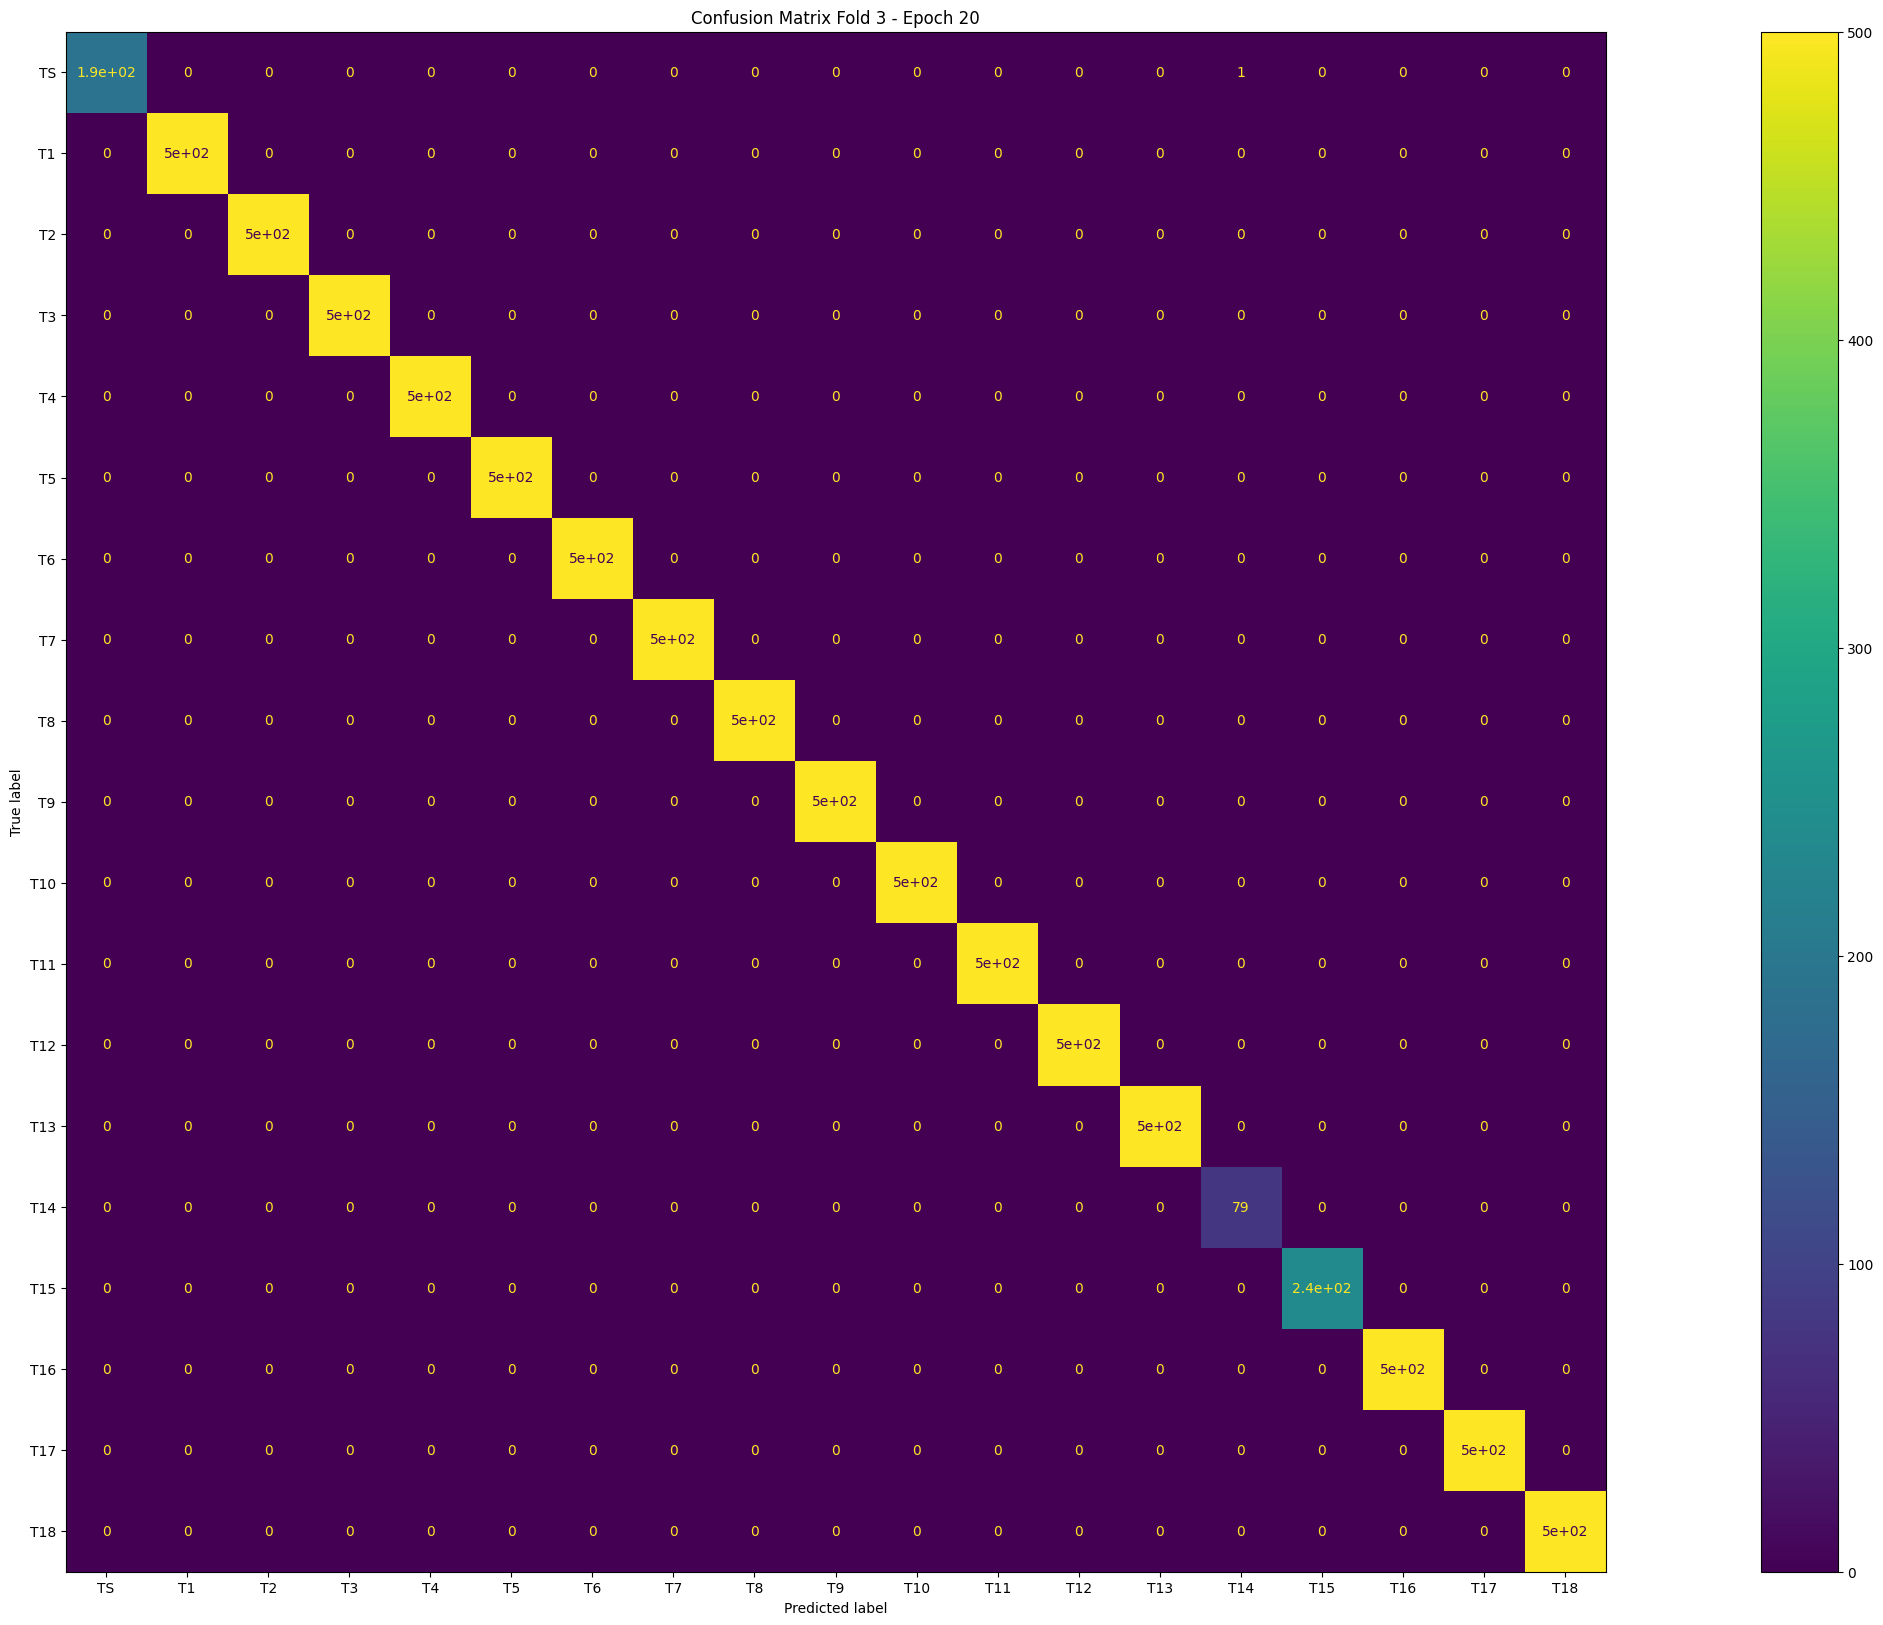

,Amount of Data,Accuracy,Precision,Recall,F One
TS,191.0,0.994764,1.0000,0.994764,0.997375
T1,500.0,1.000000,1.0000,1.000000,1.000000
T2,500.0,1.000000,1.0000,1.000000,1.000000
T3,500.0,1.000000,1.0000,1.000000,1.000000
T4,500.0,1.000000,1.0000,1.000000,1.000000
T5,500.0,1.000000,1.0000,1.000000,1.000000
T6,500.0,1.000000,1.0000,1.000000,1.000000
T7,500.0,1.000000,1.0000,1.000000,1.000000
T8,500.0,1.000000,1.0000,1.000000,1.000000
T9,500.0,1.000000,1.0000,1.000000,1.000000



Average loss di testing data: 3.2089182245348076e-06


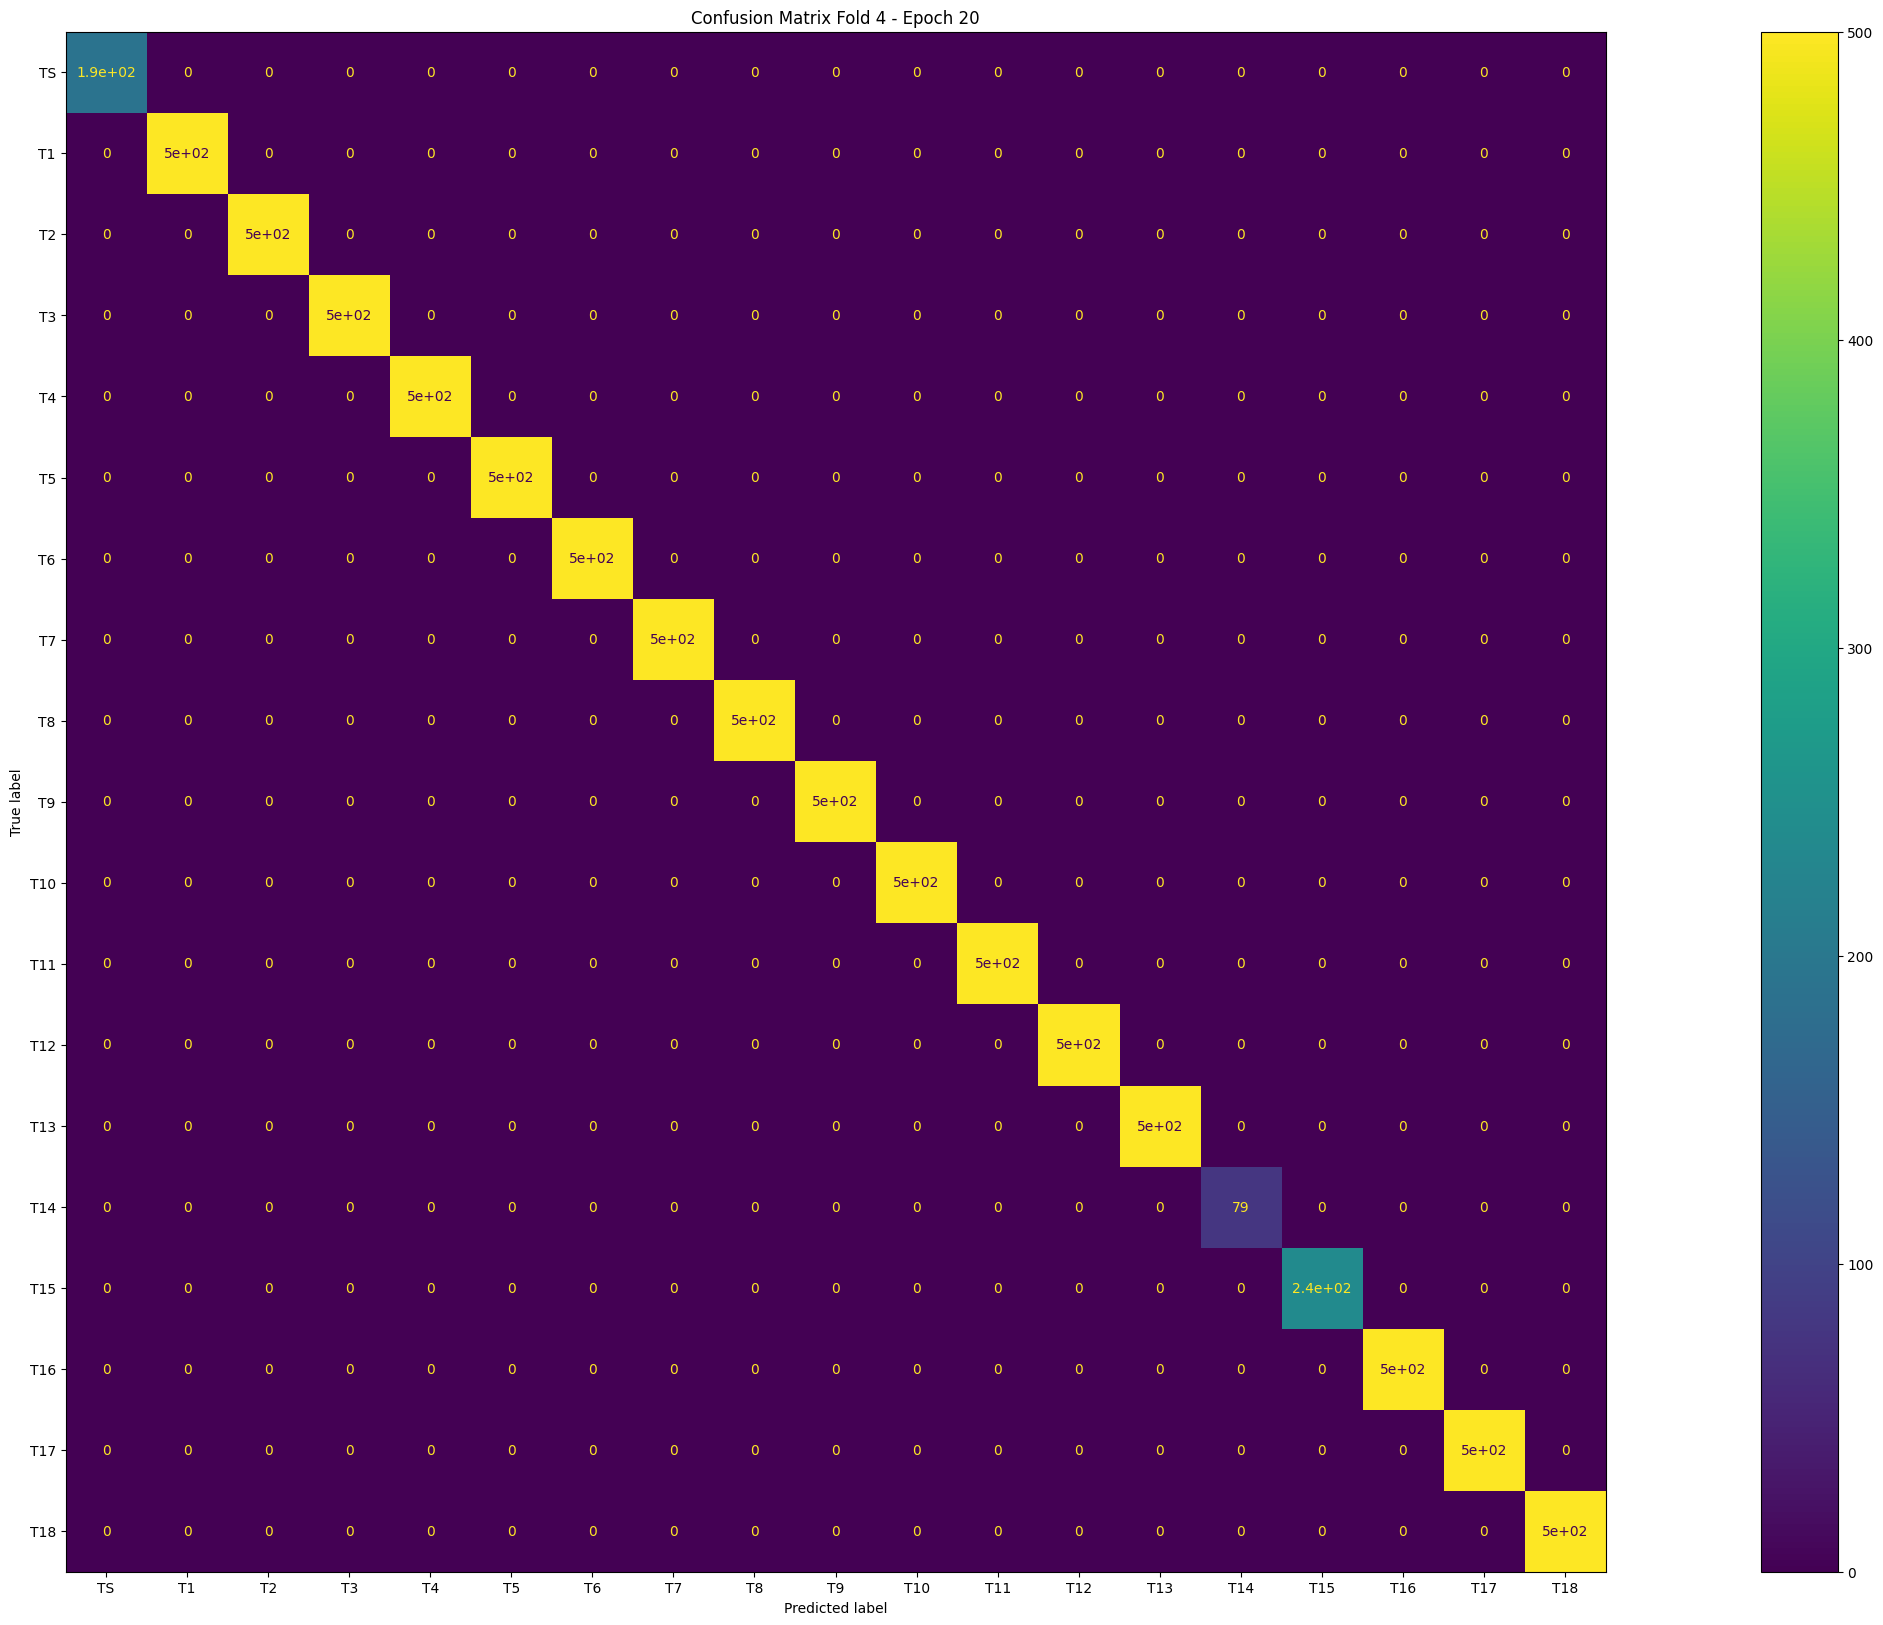

,Amount of Data,Accuracy,Precision,Recall,F One
TS,191.0,1.0,1.0,1.0,1.0
T1,500.0,1.0,1.0,1.0,1.0
T2,500.0,1.0,1.0,1.0,1.0
T3,500.0,1.0,1.0,1.0,1.0
T4,500.0,1.0,1.0,1.0,1.0
T5,500.0,1.0,1.0,1.0,1.0
T6,500.0,1.0,1.0,1.0,1.0
T7,500.0,1.0,1.0,1.0,1.0
T8,500.0,1.0,1.0,1.0,1.0
T9,500.0,1.0,1.0,1.0,1.0



Average loss di testing data: 4.6549927283528335e-06


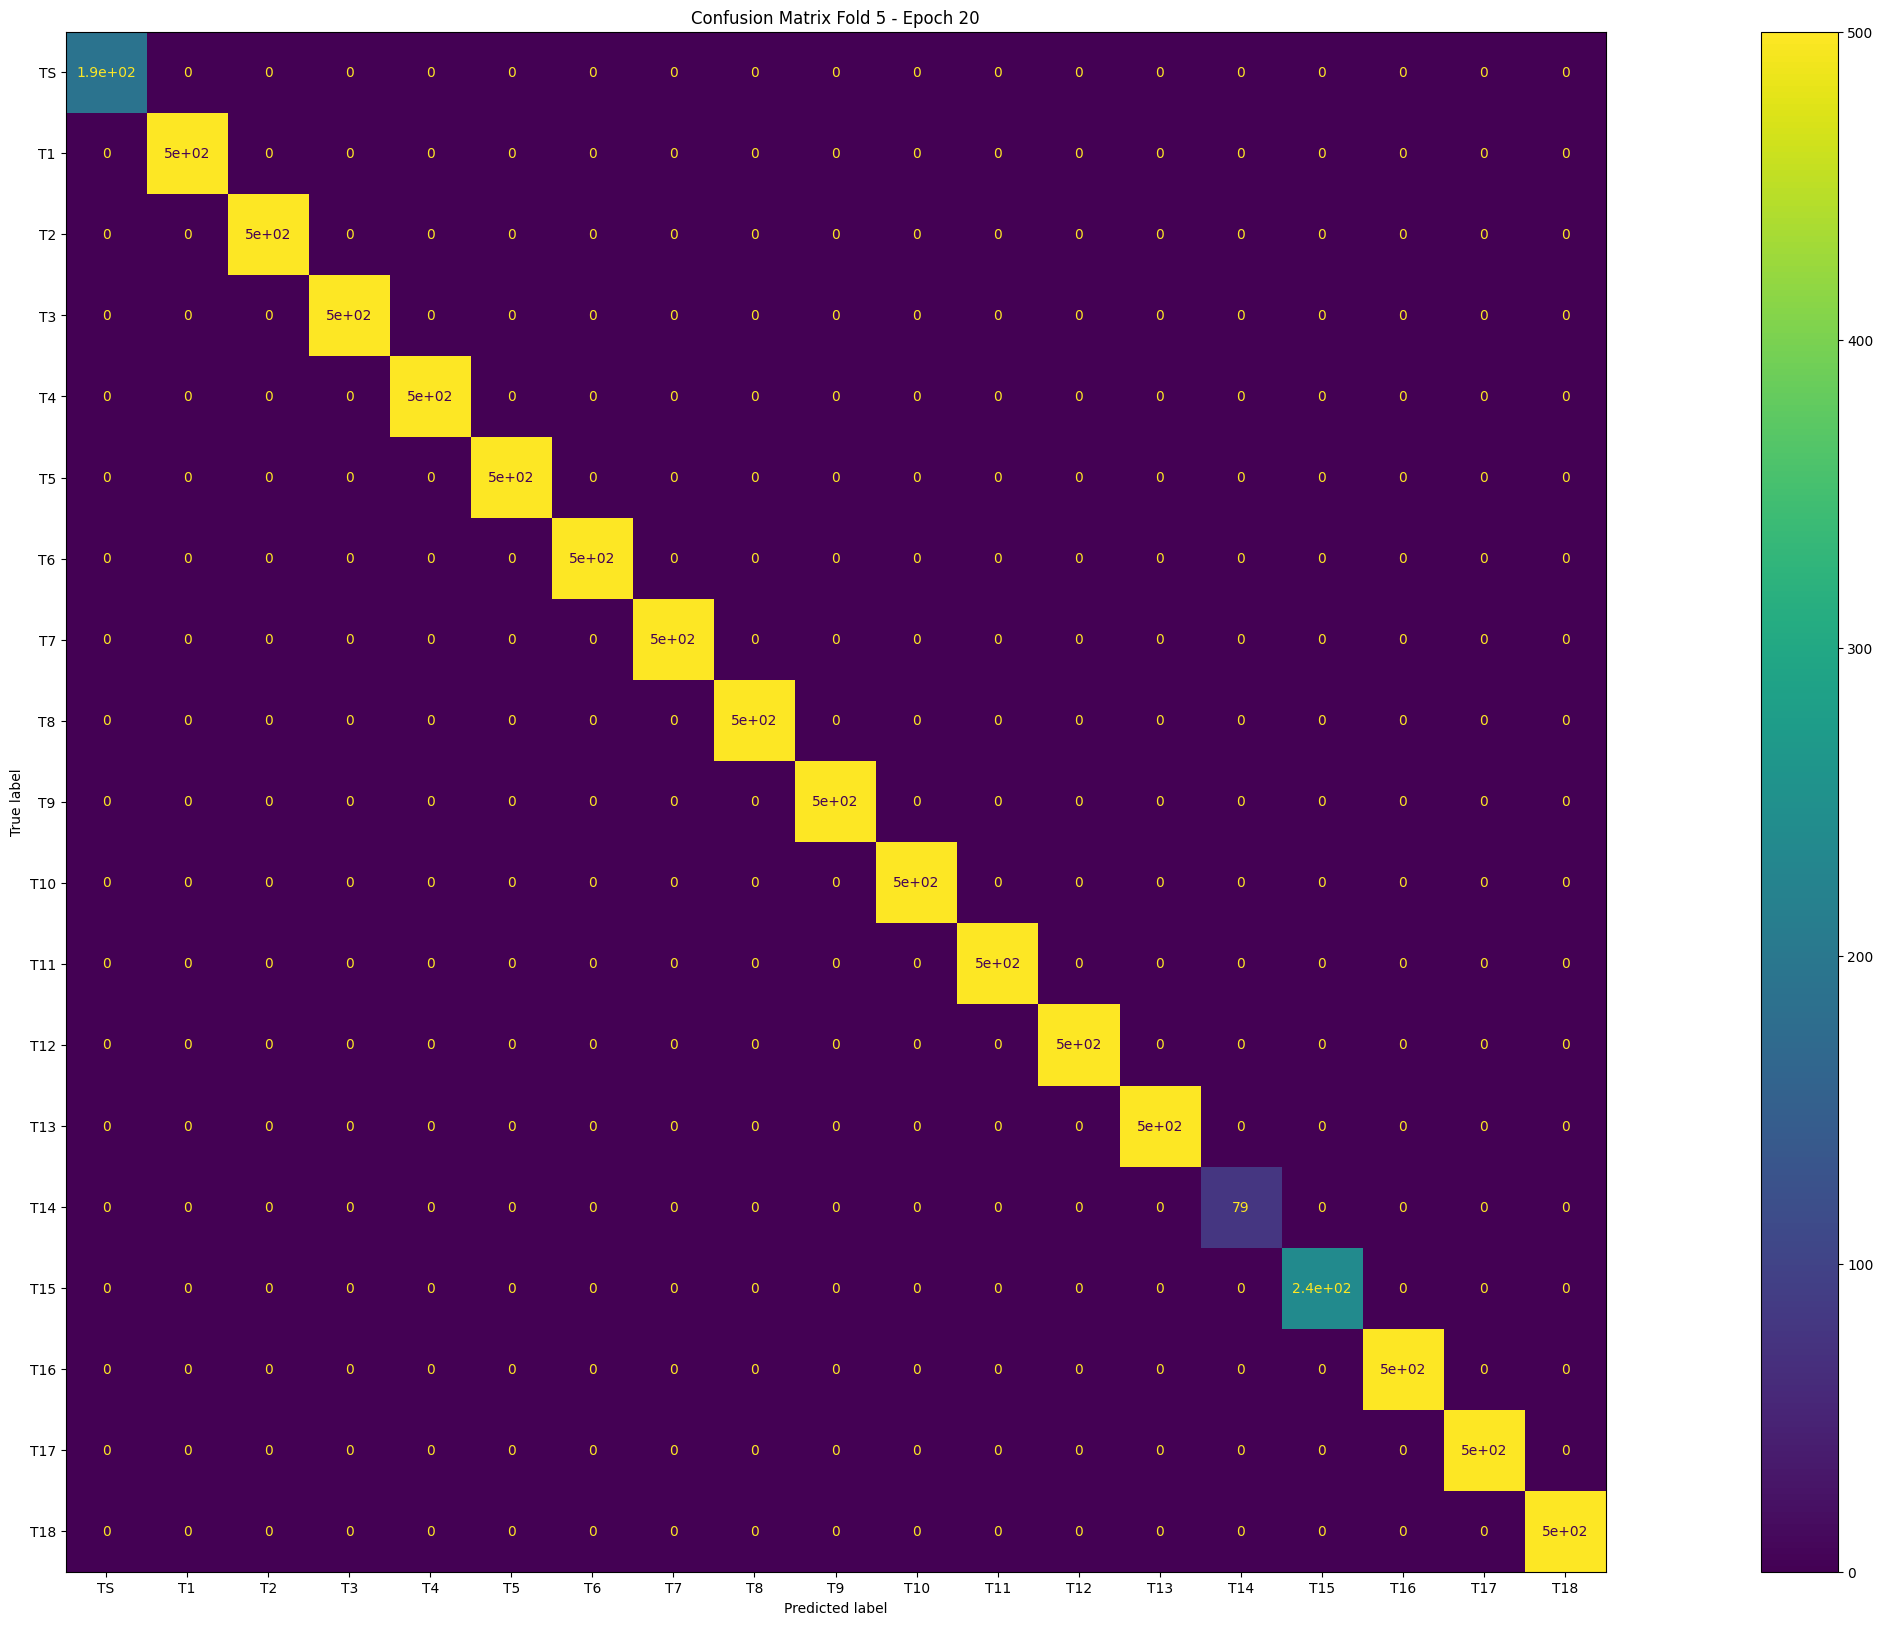

,Amount of Data,Accuracy,Precision,Recall,F One
TS,191.0,1.0,1.0,1.0,1.0
T1,500.0,1.0,1.0,1.0,1.0
T2,500.0,1.0,1.0,1.0,1.0
T3,500.0,1.0,1.0,1.0,1.0
T4,500.0,1.0,1.0,1.0,1.0
T5,500.0,1.0,1.0,1.0,1.0
T6,500.0,1.0,1.0,1.0,1.0
T7,500.0,1.0,1.0,1.0,1.0
T8,500.0,1.0,1.0,1.0,1.0
T9,500.0,1.0,1.0,1.0,1.0


In [52]:
for fold_i in range(5):

  tr_loss = 0

  save_path = 'model_semantic/class_checkpoint/fold_' + str(fold_i)
  model_class_path = os.path.join(save_path, "indobert_class_semantic_checkpoint_19.pth")
  model = torch.load(model_class_path)

  model.to(DEVICE)

  model.eval()

  nb_classes = 19

  true_recaps = [[] for i in range(5)]
  false_recaps = [[] for i in range(5)]

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      for input_recap, gold_recap, pred_recap in zip(input.to('cpu'), gold.to('cpu'), pred.to('cpu')):
        input_recap_sentence = tokenizer_class.decode(input_recap)
        _, gold_idx = torch.max(gold_recap, 0)
        _, pred_idx = torch.max(pred_recap, 0)
        if gold_idx == pred_idx:
          true_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))
        else:
          false_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
  data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print("")
  print(f"Average loss di testing data: {avg_loss}")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['TS', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)
  plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch 20")

  plt.show()

  disp_df = pd.DataFrame(data=data_conf,
                          index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
  display(disp_df)

In [53]:
save_path = 'model_semantic/class_checkpoint/fold_3'
model_class_path = os.path.join(save_path, "indobert_class_semantic_checkpoint_19.pth")
model = torch.load(model_class_path)

# bert_class = model_class

save_path = 'model/class/'
!mkdir -p model/class/
model_class_path = os.path.join(save_path, "indobert_class_semantic"+".pth")

model.to('cpu')
torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
df_true_recaps = pd.DataFrame(true_recaps[3], columns=['question', 'true_label', 'pred_label'])

save_path = 'semantic/dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_true_recaps.to_csv('semantic/dataset/semantic_classification_true_recaps.csv', index=False)

In [55]:
df_false_recaps = pd.DataFrame(false_recaps[3], columns=['question', 'true_label', 'pred_label'])

save_path = 'semantic/dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_false_recaps.to_csv('semantic/dataset/semantic_classification_false_recaps.csv', index=False)

## Archive

### 1st Try, 300~ EPOCH

In [ ]:
import time

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 500

model.to(DEVICE)

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

for epoch_i in range(0, EPOCH):
  start = time.time()
  print(f"Epoch {epoch_i + 1} / {EPOCH}")

  # Freeze all layers
  for param in model.parameters():
      param.requires_grad = False

  # Unfreeze last layer
  for param in model.bert.encoder.layer[11].parameters():
      param.requires_grad = True

  # Reset the total loss for this epoch.
  tr_loss = 0

  # Put the model into training mode.
  model.train()

  # Untuk setiap data di training data
  for data in train_instances:

    # Mendapatkan output dari model
    input, gold = data
    input = input.to(DEVICE)
    gold = gold.to(DEVICE)
    pred = model(input)

    # Categorical Cross-Entropy --- Loss Function
    loss = loss_func(pred, gold)

    # Agar gradient tidak menumpuk; ini diperlukan sebelum
    # menghitung gradient dengan loss.backward()
    optimizer.zero_grad()

    # hitung gradient
    loss.backward()

    # update parameter
    optimizer.step()

    # akumulasi loss dalam 1 epoch
    tr_loss += loss.item()

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / train_size

  print(f"Average loss: {avg_loss}")

  ### Uji coba di Validation Data
  print("Uji coba di Validation Data ...")

  # model eval, agar layer seperti dropout yang menghasilkan
  # sesuai yang random tidak digunakan
  model.eval()

  val_loss = 0
  pred_labels = []
  true_labels = []

  # Untuk setiap batch di validation data
  for data in valid_instances:

    # jangan track gradient! ini sedang evaluasi, bukan training
    with torch.no_grad():

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # akumulasi loss di validation set
      val_loss += loss.item()

    # akumulasi prediksi
    # _, pred_l = torch.max(output, dim = 1) # outnya adalah 2-tuple: (max, max_indices)
    # pred_labels += pred_l.detach().cpu()
    # _, true_l = torch.max(y, dim = 1)
    # true_labels += true_l.detach().cpu()

  # average loss
  avg_val_loss = val_loss / val_size

  # accuracy
  # pred_labels = torch.stack(pred_labels).numpy()
  # true_labels = torch.stack(true_labels).numpy()
  # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
  print(f"Average loss di validation data: {avg_val_loss}")
  # print(f"Accuracy di validation data: {val_accuracy}")

  print("")

  end = time.time()
  print("Time " + str(end-start))

  if epoch_i % 100 == 0:
    save_path = 'model/class_checkpoint/'
    !mkdir -p model/class_checkpoint/
    model_class_path = os.path.join(save_path, "indobert_class_checkpoint_" + str(epoch_i) +".pth")
    torch.save(model, model_class_path)

### 2nd Try, 500 EPOCH, Tesaurus

In [ ]:
import time

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 500

model.to(DEVICE)

training_losses = []
validation_losses = []

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

for epoch_i in range(0, EPOCH):
  start = time.time()
  print(f"Epoch {epoch_i + 1} / {EPOCH}")

  # Freeze all layers
  for param in model.parameters():
      param.requires_grad = False

  # Unfreeze last layer
  for param in model.bert.encoder.layer[11].parameters():
      param.requires_grad = True

  # Reset the total loss for this epoch.
  tr_loss = 0

  # Put the model into training mode.
  model.train()

  # Untuk setiap data di training data
  for data in train_instances:

    # Mendapatkan output dari model
    input, gold = data
    input = input.to(DEVICE)
    gold = gold.to(DEVICE)
    pred = model(input)

    # Categorical Cross-Entropy --- Loss Function
    loss = loss_func(pred, gold)

    # Agar gradient tidak menumpuk; ini diperlukan sebelum
    # menghitung gradient dengan loss.backward()
    optimizer.zero_grad()

    # hitung gradient
    loss.backward()

    # update parameter
    optimizer.step()

    # akumulasi loss dalam 1 epoch
    tr_loss += loss.item()

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / train_size

  training_losses.append(avg_loss)

  print(f"Average loss: {avg_loss}")

  ### Uji coba di Validation Data
  print("Uji coba di Validation Data ...")

  # model eval, agar layer seperti dropout yang menghasilkan
  # sesuai yang random tidak digunakan
  model.eval()

  val_loss = 0
  pred_labels = []
  true_labels = []

  # Untuk setiap batch di validation data
  for data in valid_instances:

    # jangan track gradient! ini sedang evaluasi, bukan training
    with torch.no_grad():

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # akumulasi loss di validation set
      val_loss += loss.item()

    # akumulasi prediksi
    # _, pred_l = torch.max(output, dim = 1) # outnya adalah 2-tuple: (max, max_indices)
    # pred_labels += pred_l.detach().cpu()
    # _, true_l = torch.max(y, dim = 1)
    # true_labels += true_l.detach().cpu()

  # average loss
  avg_val_loss = val_loss / val_size

  validation_losses.append(avg_val_loss)

  # accuracy
  # pred_labels = torch.stack(pred_labels).numpy()
  # true_labels = torch.stack(true_labels).numpy()
  # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
  print(f"Average loss di validation data: {avg_val_loss}")
  # print(f"Accuracy di validation data: {val_accuracy}")

  print("")

  end = time.time()
  print("Time " + str(end-start))

  if epoch_i % 100 == 0:
    nb_classes = 18

    conf_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
      for i, (input, gold) in enumerate(valid_instances):
        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)
        # _, gold = torch.max(gold, 1)
        # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   conf_matrix[t.long(), p.long()] += 1

        conf_matrix = confusion_matrix(gold, pred, conf_matrix)

    amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)

    print(f"Confusion Matrix in validation data:")
    display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
    disp.plot()

    for i, template_index in enumerate(display_labels):
      print(f"Evaluation for {template_index}:")
      print(f"Amount of Data: {amt[i]}")
      print(f"Accuracy: {acc[i]}")
      print(f"Precision: {prec[i]}")
      print(f"Recall: {rec[i]}")
      print(f"F One: {f1[i]}")
      print()

    save_path = 'model/class_tesaurus_checkpoint/'
    !mkdir -p model/class_tesaurus_checkpoint/
    model_class_path = os.path.join(save_path, "indobert_class_tesaurus_checkpoint_" + str(epoch_i) +".pth")
    torch.save(model, model_class_path)

In [ ]:
x = np.arange(1, 501)
y_train_loss = np.asarray(training_losses, dtype=np.float32)
y_val_loss = np.asarray(validation_losses, dtype=np.float32)

plt.figure(figsize=(40,20))

plt.plot(x, y_train_loss)
plt.plot(x, y_val_loss, '-.')

plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss per Epoch')
plt.show()

In [ ]:
x = np.arange(1, 51)
y_train_loss = np.asarray(training_losses, dtype=np.float32)
y_val_loss = np.asarray(validation_losses, dtype=np.float32)

plt.figure(figsize=(40,20))

plt.plot(x, y_train_loss[0:50])
plt.plot(x, y_val_loss[0:50], '-.')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss per Epoch')
plt.show()

In [ ]:
save_path = 'model/'
model_class_path = os.path.join(save_path, "class_tesaurus_checkpoint/indobert_class_tesaurus_checkpoint_100"+".pth")
# model_class_path = os.path.join(save_path, "class/indobert_class_v1"+".pth")

bert_class = torch.load(model_class_path)

# bert_class = model_class

In [ ]:
  tr_loss = 0

  model.to(DEVICE)

  bert_class.eval()

  nb_classes = 18

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = bert_class(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1


      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print(f"Average loss di testing data: {avg_loss}")
  print(f"Confusion Matrix in testing data: ")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)

  plt.show()

  for i, template_index in enumerate(display_labels):
      print(f"Evaluation for {template_index}:")
      print(f"Amount of Data: {amt[i]}")
      print(f"Accuracy: {acc[i]}")
      print(f"Precision: {prec[i]}")
      print(f"Recall: {rec[i]}")
      print(f"F One: {f1[i]}")
      print()